Use the embedding Binxu generated to find features. Try to find features by classifing contrastive labeled data.

## Read embeddings, extract token embedding based on contrastive classes

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import pickle
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/utils")
from cv2_eval_utils import find_classify_object_masks

positive_threshold = 180 
saveroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/latent_store"

#### Utils function to modularize positive / negative embedding extraction code

In [3]:
def get_top_obj_pos_bottom_obj_neg(latent_state, obj_df, objeect_masks):
    """
    Top object is positive, bottom object is negative. 
    No label for background. 
    """
    if len(obj_df) != 2:
        return np.empty([0, latent_state.shape[-1]]), np.empty([0, latent_state.shape[-1]])
    
    if obj_df.iloc[0]['Center (x, y)'][1] < obj_df.iloc[1]['Center (x, y)'][1]:
        positive_embeddings = latent_state[objeect_masks[0], :].numpy()
        negative_embeddings = latent_state[objeect_masks[1], :].numpy()
    else:
        positive_embeddings = latent_state[objeect_masks[1], :].numpy()
        negative_embeddings = latent_state[objeect_masks[0], :].numpy()
    return [positive_embeddings], [negative_embeddings]


def get_top_obj_pos_others_neg(latent_state, obj_df, objeect_masks):
    """
    Top object is positive, others are negative including background. 
    """
    if len(obj_df) != 2:
        return np.empty([0, latent_state.shape[-1]]), np.empty([0, latent_state.shape[-1]])
    
    if obj_df.iloc[0]['Center (x, y)'][1] < obj_df.iloc[1]['Center (x, y)'][1]:
        positive_embeddings = latent_state[objeect_masks[0], :].numpy()
        negative_embeddings = latent_state[~objeect_masks[0], :].numpy()
    else:
        positive_embeddings = latent_state[objeect_masks[1], :].numpy()
        negative_embeddings = latent_state[~objeect_masks[1], :].numpy()
    return [positive_embeddings], [negative_embeddings]


def get_triangle_pos_others_neg(latent_state, obj_df, objeect_masks):
    """
    Top object is positive, others are negative including background. 
    """
    # if len(obj_df) != 2:
    #     return np.empty([0, latent_state.shape[-1]]), np.empty([0, latent_state.shape[-1]])
    positive_embeddings = [np.empty([0, latent_state.shape[-1]])]
    negative_embeddings = [np.empty([0, latent_state.shape[-1]])]
    for i in range(len(obj_df)):
        if obj_df.iloc[i]['Shape'] == "Triangle":
            positive_embeddings.append(latent_state[objeect_masks[i], :].numpy())
            negative_embeddings.append(latent_state[~objeect_masks[i], :].numpy())
    # positive_embeddings = np.vstack(positive_embeddings)
    # negative_embeddings = np.vstack(negative_embeddings)
    return positive_embeddings, negative_embeddings


def get_red_triangle_pos_others_neg(latent_state, obj_df, objeect_masks):
    """
    Top object is positive, others are negative including background. 
    """
    # if len(obj_df) != 2:
    #     return np.empty([0, latent_state.shape[-1]]), np.empty([0, latent_state.shape[-1]])
    positive_embeddings = [np.empty([0, latent_state.shape[-1]])]
    negative_embeddings = [np.empty([0, latent_state.shape[-1]])]
    for i in range(len(obj_df)):
        if obj_df.iloc[i]['Shape'] == "Triangle" and obj_df.iloc[i]['Color (RGB)'][0] > 225 and \
            obj_df.iloc[i]['Color (RGB)'][1] < 30 and obj_df.iloc[i]['Color (RGB)'][2] < 30:
            positive_embeddings.append(latent_state[objeect_masks[i], :].numpy())
            negative_embeddings.append(latent_state[~objeect_masks[i], :].numpy())
    # positive_embeddings = np.vstack(positive_embeddings)
    # negative_embeddings = np.vstack(negative_embeddings)
    return positive_embeddings, negative_embeddings

In [83]:
obj_df

Object   Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       2  Circle  (250, 2, 7)      (89, 47)   773.0     804.247719
1       1  Square  (7, 4, 251)     (77, 107)  1058.0    1024.000000

In [113]:
# try to classify top (+) and down (-) objects
def collect_pos_neg_embeddings(saveroot, t_index, prompt_ids, seed_ids=range(10), diffusion_pass=("cond",),
                               get_pos_neg_embeddings_func=get_top_obj_pos_others_neg):
    positive_embeddings = [] 
    negative_embeddings = []
    # 0,1,8,9 are the prompts that have above or below.
    for prompt_idx in tqdm(prompt_ids):
        for seed_idx in seed_ids:
            latent_file = f"red_blue_8_pos_rndembposemb_img_latent_residual_prompt{prompt_idx}_seed{seed_idx}.pkl"
            latent_path = os.path.join(saveroot, latent_file)
            data = pickle.load(open(latent_path, 'rb'))

            image_logs = data['image_logs']
            batch_size = len(image_logs[0]['images'])
            residual_state_traj = data['block_11_residual_spatial_state_traj']
            for image_idx in range(batch_size):
                obj_df, obj_masks = find_classify_object_masks(image_logs[0]['images'][image_idx])
                if len(obj_df) != 2:
                    continue
                obj_masks_resized = [cv2.resize(obj_mask, (8, 8)) for obj_mask in obj_masks]
                obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
                for which_pass in diffusion_pass:
                    if which_pass == "cond":
                        pos_embeddings, neg_embeddings = get_pos_neg_embeddings_func(residual_state_traj[t_index, batch_size + image_idx], 
                                                                                        obj_df, obj_masks_resized_binary)
                    elif which_pass == "uncond":
                        pos_embeddings, neg_embeddings = get_pos_neg_embeddings_func(residual_state_traj[t_index, image_idx], 
                                                                                        obj_df, obj_masks_resized_binary)
                    else:
                        raise ValueError(f"Invalid diffusion pass: {which_pass} (should be in ['cond', 'uncond'])")
                    positive_embeddings.extend(pos_embeddings)
                    negative_embeddings.extend(neg_embeddings)  

    positive_embeddings = np.vstack(positive_embeddings)
    negative_embeddings = np.vstack(negative_embeddings)
    return positive_embeddings, negative_embeddings

In [17]:
# try to classify top (+) and down (-) objects

positive_embeddings = []
negative_embeddings = []

t_index = 7

# 0,1,8,9 are the prompts that have above or below.
for prompt_idx in [0,1,8,9]:
    for seed_idx in trange(10):
        latent_file = f"red_blue_8_pos_rndembposemb_img_latent_residual_prompt{prompt_idx}_seed{seed_idx}.pkl"
        latent_path = os.path.join(saveroot, latent_file)

        with open(latent_path, 'rb') as f:
            data = pickle.load(f)
        image_logs = data['image_logs']
        batch_size = len(image_logs[0]['images'])
        residual_state_traj = data['block_11_residual_spatial_state_traj']
        for image_idx in range(batch_size):
            obj_df, obj_masks = find_classify_object_masks(image_logs[0]['images'][image_idx])
            if len(obj_df) != 2:
                continue
            obj_masks_resized = [cv2.resize(obj_mask, (8, 8)) for obj_mask in obj_masks]
            obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
            pos_embeddings, neg_embeddings = get_top_obj_pos_others_neg(residual_state_traj[t_index, batch_size + image_idx], 
                                                                            obj_df, obj_masks_resized_binary)
            positive_embeddings.extend(pos_embeddings)
            negative_embeddings.extend(neg_embeddings)  

positive_embeddings = np.vstack(positive_embeddings)
negative_embeddings = np.vstack(negative_embeddings)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
residual_state_traj[t_index][batch_size + image_idx][~obj_masks_resized_binary[0],:].shape

torch.Size([62, 768])

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy: 0.988
Test accuracy: 0.983


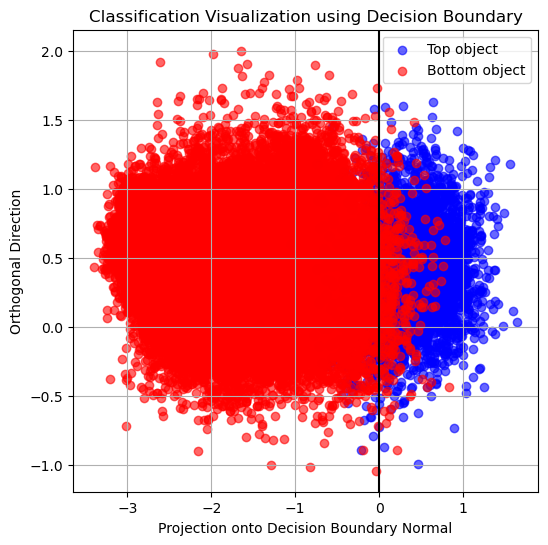

In [20]:
# Combine positive and negative samples
X = np.vstack([positive_embeddings, negative_embeddings])
# Create labels (1 for positive, 0 for negative)
y = np.concatenate([np.ones(len(positive_embeddings)), np.zeros(len(negative_embeddings))])

# Train a linear classifier (using logistic regression)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier
clf = LogisticRegression(random_state=42, fit_intercept=False)
clf.fit(X_train, y_train)

# Evaluate performance
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print(f"Training accuracy: {train_score:.3f}")
print(f"Test accuracy: {test_score:.3f}")

# Get the decision boundary normal vector (feature importance)
feature_importance = clf.coef_[0]

# Visualize the classification using boundary normal vector as one axis
# Get the normalized decision boundary vector
boundary_vector = feature_importance / np.linalg.norm(feature_importance)

# Project data onto boundary vector for first dimension
X_boundary = X @ boundary_vector

# Get an orthogonal vector for the second dimension
# Use the first vector that's not parallel to boundary_vector
basis_vector = np.zeros_like(boundary_vector)
basis_vector[0] = 1
orthogonal = basis_vector - (basis_vector @ boundary_vector) * boundary_vector
orthogonal = orthogonal / np.linalg.norm(orthogonal)

# Project data onto orthogonal vector for second dimension
X_orthogonal = X @ orthogonal

# Combine into 2D coordinates
X_proj = np.column_stack([X_boundary, X_orthogonal])

# Split into positive and negative samples
X_pos = X_proj[y==1]
X_neg = X_proj[y==0]

# Create scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(X_pos[:, 0], X_pos[:, 1], c='blue', label='Top object', alpha=0.6)
plt.scatter(X_neg[:, 0], X_neg[:, 1], c='red', label='Bottom object', alpha=0.6)

# Plot decision boundary (vertical line at x=0 since boundary_vector is one axis)
plt.axvline(x=0, color='k', linestyle='-')

plt.xlabel('Projection onto Decision Boundary Normal')
plt.ylabel('Orthogonal Direction')
plt.title('Classification Visualization using Decision Boundary')
plt.legend()
plt.grid(True)
plt.show()


### Modularized functions for linear probe training

In [112]:
from sklearn.metrics import confusion_matrix
def train_classifier(positive_embeddings, negative_embeddings, test_size=0.2, random_state=42, fit_intercept=False, solver='lbfgs', max_iter=100):
    """
    Train a logistic regression classifier to classify positive and negative embeddings. 
    No intercept / bias is added. 
    """
    # Combine positive and negative samples
    X = np.vstack([positive_embeddings, negative_embeddings])
    # Create labels (1 for positive, 0 for negative)
    y = np.concatenate([np.ones(len(positive_embeddings)), np.zeros(len(negative_embeddings))])
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Train the classifier
    clf = LogisticRegression(random_state=random_state, fit_intercept=fit_intercept, max_iter=max_iter, solver=solver)
    clf.fit(X_train, y_train)
    # Evaluate performance
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print(f"Training accuracy: {train_score:.3f}")
    print(f"Test accuracy: {test_score:.3f}")
    # compute the confusion matrix
    cm = confusion_matrix(y_test, clf.predict(X_test))
    print("Confusion matrix: \n", cm)
    print(f"Precision (TP / (TP + FP)): {cm[1,1] / (cm[1,1] + cm[1,0]):.3f}")
    print(f"Recall (TP / (TP + FN)): {cm[1,1] / (cm[1,1] + cm[0,1]):.3f}")
    eval_dict = {
        "classifier": clf, 
        "train_score": train_score,
        "test_score": test_score,
        "confusion_matrix": cm,
        "precision": cm[1,1] / (cm[1,1] + cm[1,0]),
        "recall": cm[1,1] / (cm[1,1] + cm[0,1]),
        "f1_score": 2 * cm[1,1] / (2 * cm[1,1] + cm[1,0] + cm[0,1]),
    }
    return clf, X, y, eval_dict


def get_projection_basis(clf):
    # Get the decision boundary normal vector (feature importance)
    feature_importance = clf.coef_[0]
    # Get the normalized decision boundary vector
    boundary_vector = feature_importance / np.linalg.norm(feature_importance)
    # Get an orthogonal vector for the second dimension
    basis_vector = np.zeros_like(boundary_vector)
    basis_vector[0] = 1
    orthogonal = basis_vector - (basis_vector @ boundary_vector) * boundary_vector
    orthogonal = orthogonal / np.linalg.norm(orthogonal)
    return boundary_vector, orthogonal


def project_data(X, boundary_vector, orthogonal):
    # Project data onto boundary vector and orthogonal vector
    X_boundary = X @ boundary_vector
    X_orthogonal = X @ orthogonal
    return np.column_stack([X_boundary, X_orthogonal])


def plot_classification(X_proj, y, title="Classification Visualization using Decision Boundary", s=9, alpha=0.3):
    # Split into positive and negative samples
    X_pos = X_proj[y==1]
    X_neg = X_proj[y==0]

    # Create scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(X_pos[:, 0], X_pos[:, 1], s=s, c='blue', label='Top object', alpha=alpha)
    plt.scatter(X_neg[:, 0], X_neg[:, 1], s=s, c='red', label='Bottom object', alpha=alpha) 
    # Plot decision boundary (vertical line at x=0 since boundary_vector is one axis)
    plt.axvline(x=0, color='k', linestyle='-')
    
    plt.xlabel('Projection onto Decision Boundary Normal')
    plt.ylabel('Orthogonal Direction')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


def train_classifier_and_visualize(positive_embeddings, negative_embeddings, visualize=True, s=9, alpha=0.3, solver='lbfgs', max_iter=100):
    # Train classifier and get data
    clf, X, y, eval_dict = train_classifier(positive_embeddings, negative_embeddings, solver=solver, max_iter=max_iter)
    # Get projection vectors
    boundary_vector, orthogonal = get_projection_basis(clf)
    if visualize:
        # Project the data
        X_proj = project_data(X, boundary_vector, orthogonal)
        # Visualize the results
        plot_classification(X_proj, y, s=s, alpha=alpha)
    return clf, boundary_vector, eval_dict


In [108]:
def visualize_vecprod_activation_heatmap(boundary_vector, saveroot, t_index, prompt_idx, seed_idx=0, use_relu=True):
    latent_file = f"red_blue_8_pos_rndembposemb_img_latent_residual_prompt{prompt_idx}_seed{seed_idx}.pkl"
    latent_path = os.path.join(saveroot, latent_file)
    with open(latent_path, 'rb') as f:
        data = pickle.load(f)
    prompt = data['prompt']
    image_logs = data['image_logs']
    batch_size = len(image_logs[0]['images'])
    residual_state_traj = data['block_11_residual_spatial_state_traj']
    if use_relu:
        activation = torch.relu(residual_state_traj @ boundary_vector) # (t steps, batch size, 8, 8)
    else:
        activation = (residual_state_traj @ boundary_vector) # (t steps, batch size, 8, 8)
    figh, axs = plt.subplots(5, 15, figsize=(35, 15))
    axs = axs.flatten()
    for i in range(batch_size):
        axs[3*i].imshow(image_logs[0]['images'][i])
        axs[3*i].axis('off')
        axs[3*i+1].imshow(activation[t_index, i].reshape(8, 8))
        axs[3*i+1].axis('off')
        axs[3*i+1].set_title(f"uncond")
        axs[3*i+2].imshow(activation[t_index, batch_size + i].reshape(8, 8))
        axs[3*i+2].axis('off')
        axs[3*i+2].set_title(f"cond")
    plt.suptitle(f"{prompt} t index={t_index} seed={seed_idx}, {'Relu' if use_relu else ''} dot prod activation", fontsize=18)
    plt.tight_layout()
    plt.show()
    return figh


In [110]:
figdir = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/Figure_latent_feature_heatmap'

  0%|          | 0/16 [00:00<?, ?it/s]

Training accuracy: 0.981
Test accuracy: 0.976
Confusion matrix: 
 [[12268    77]
 [  229   137]]
Precision (TP / (TP + FP)): 0.374
Recall (TP / (TP + FN)): 0.640


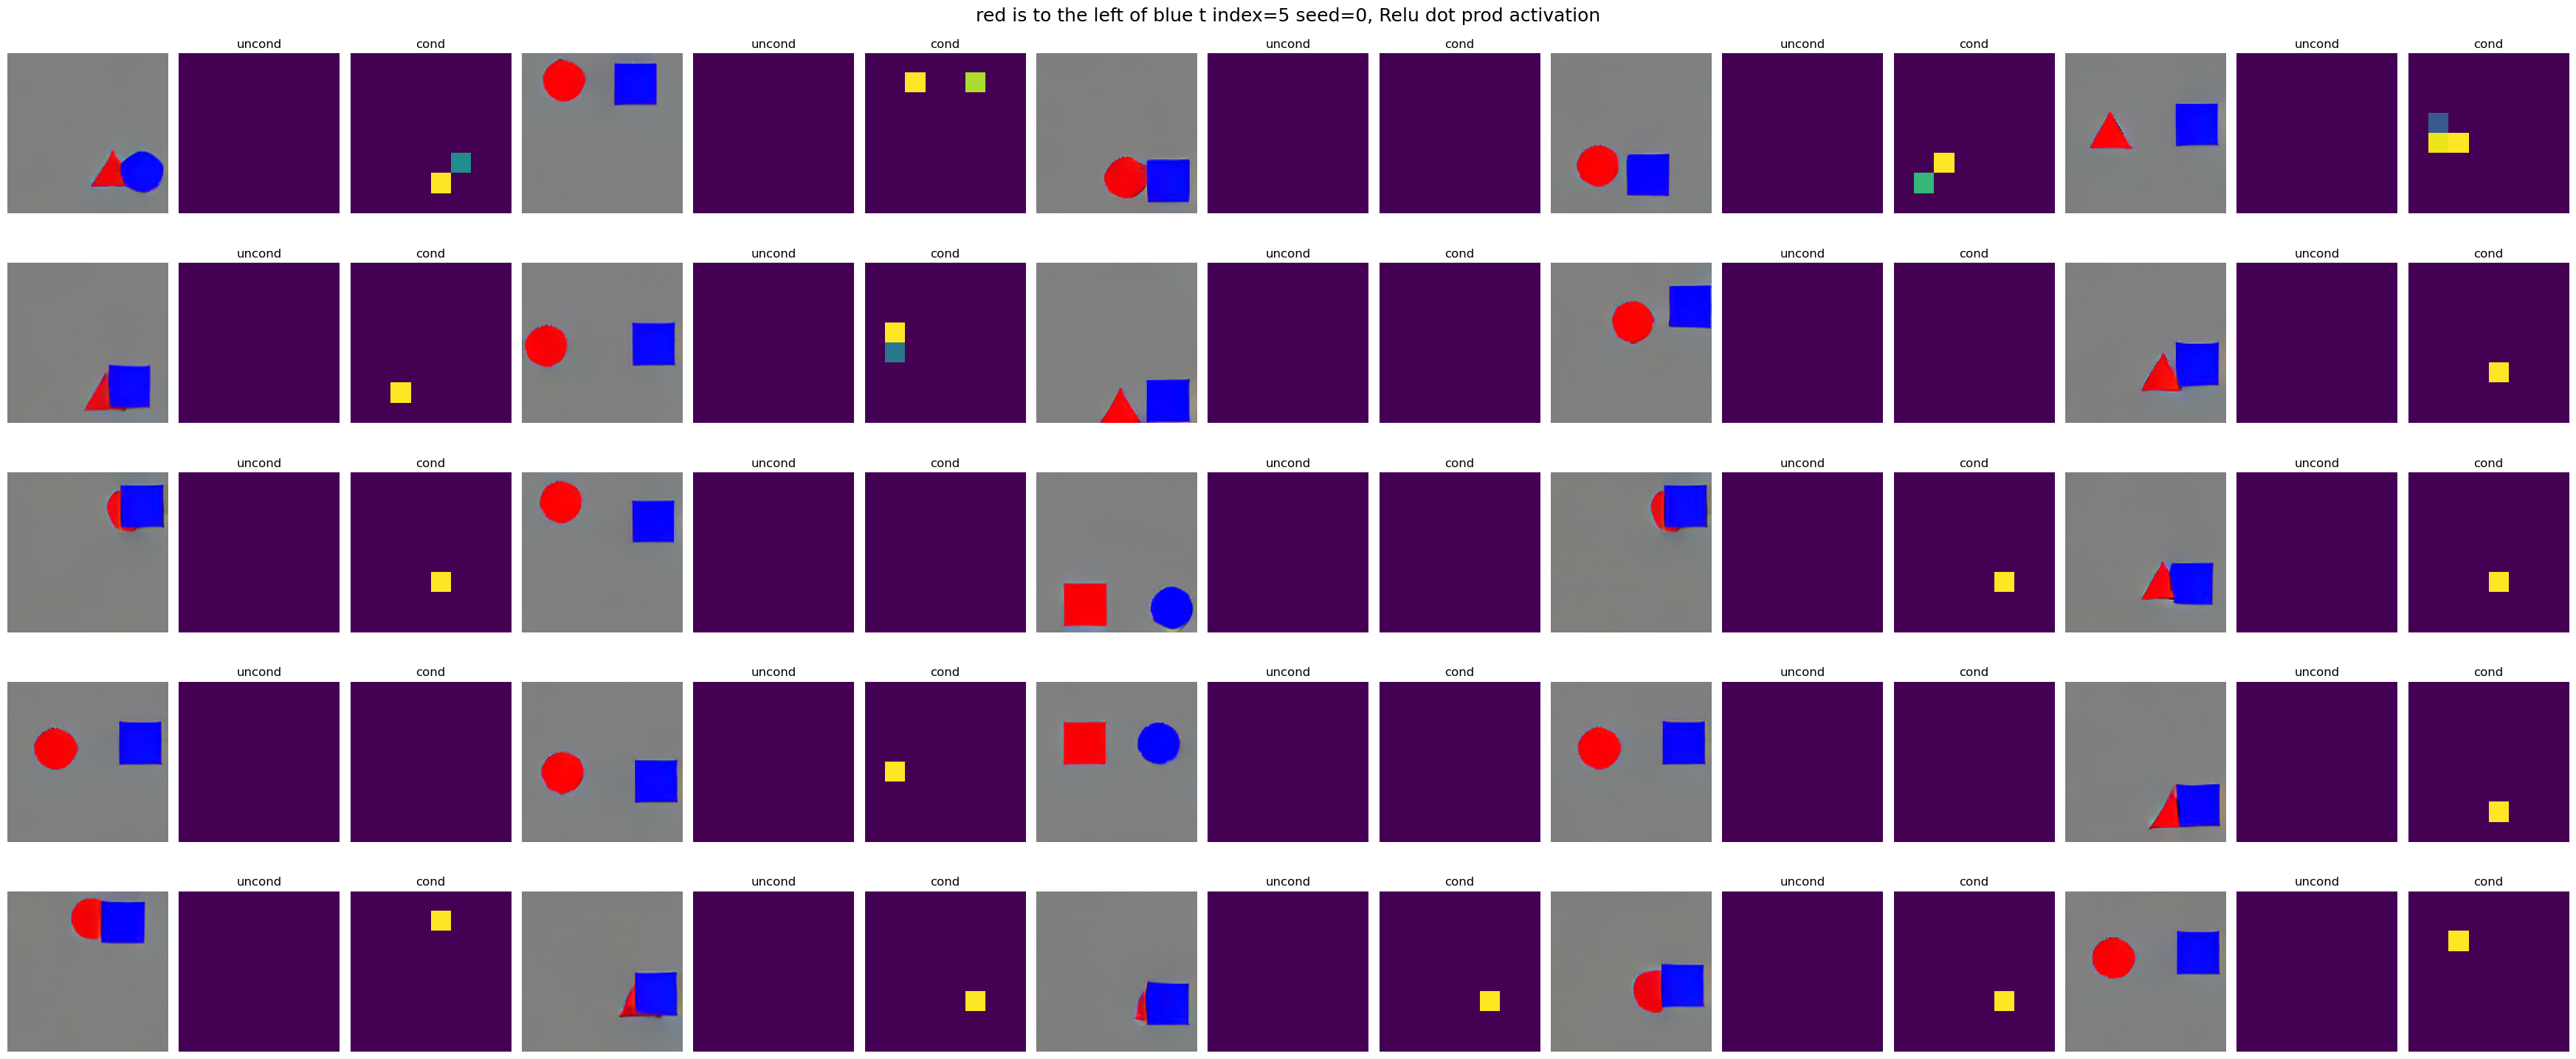

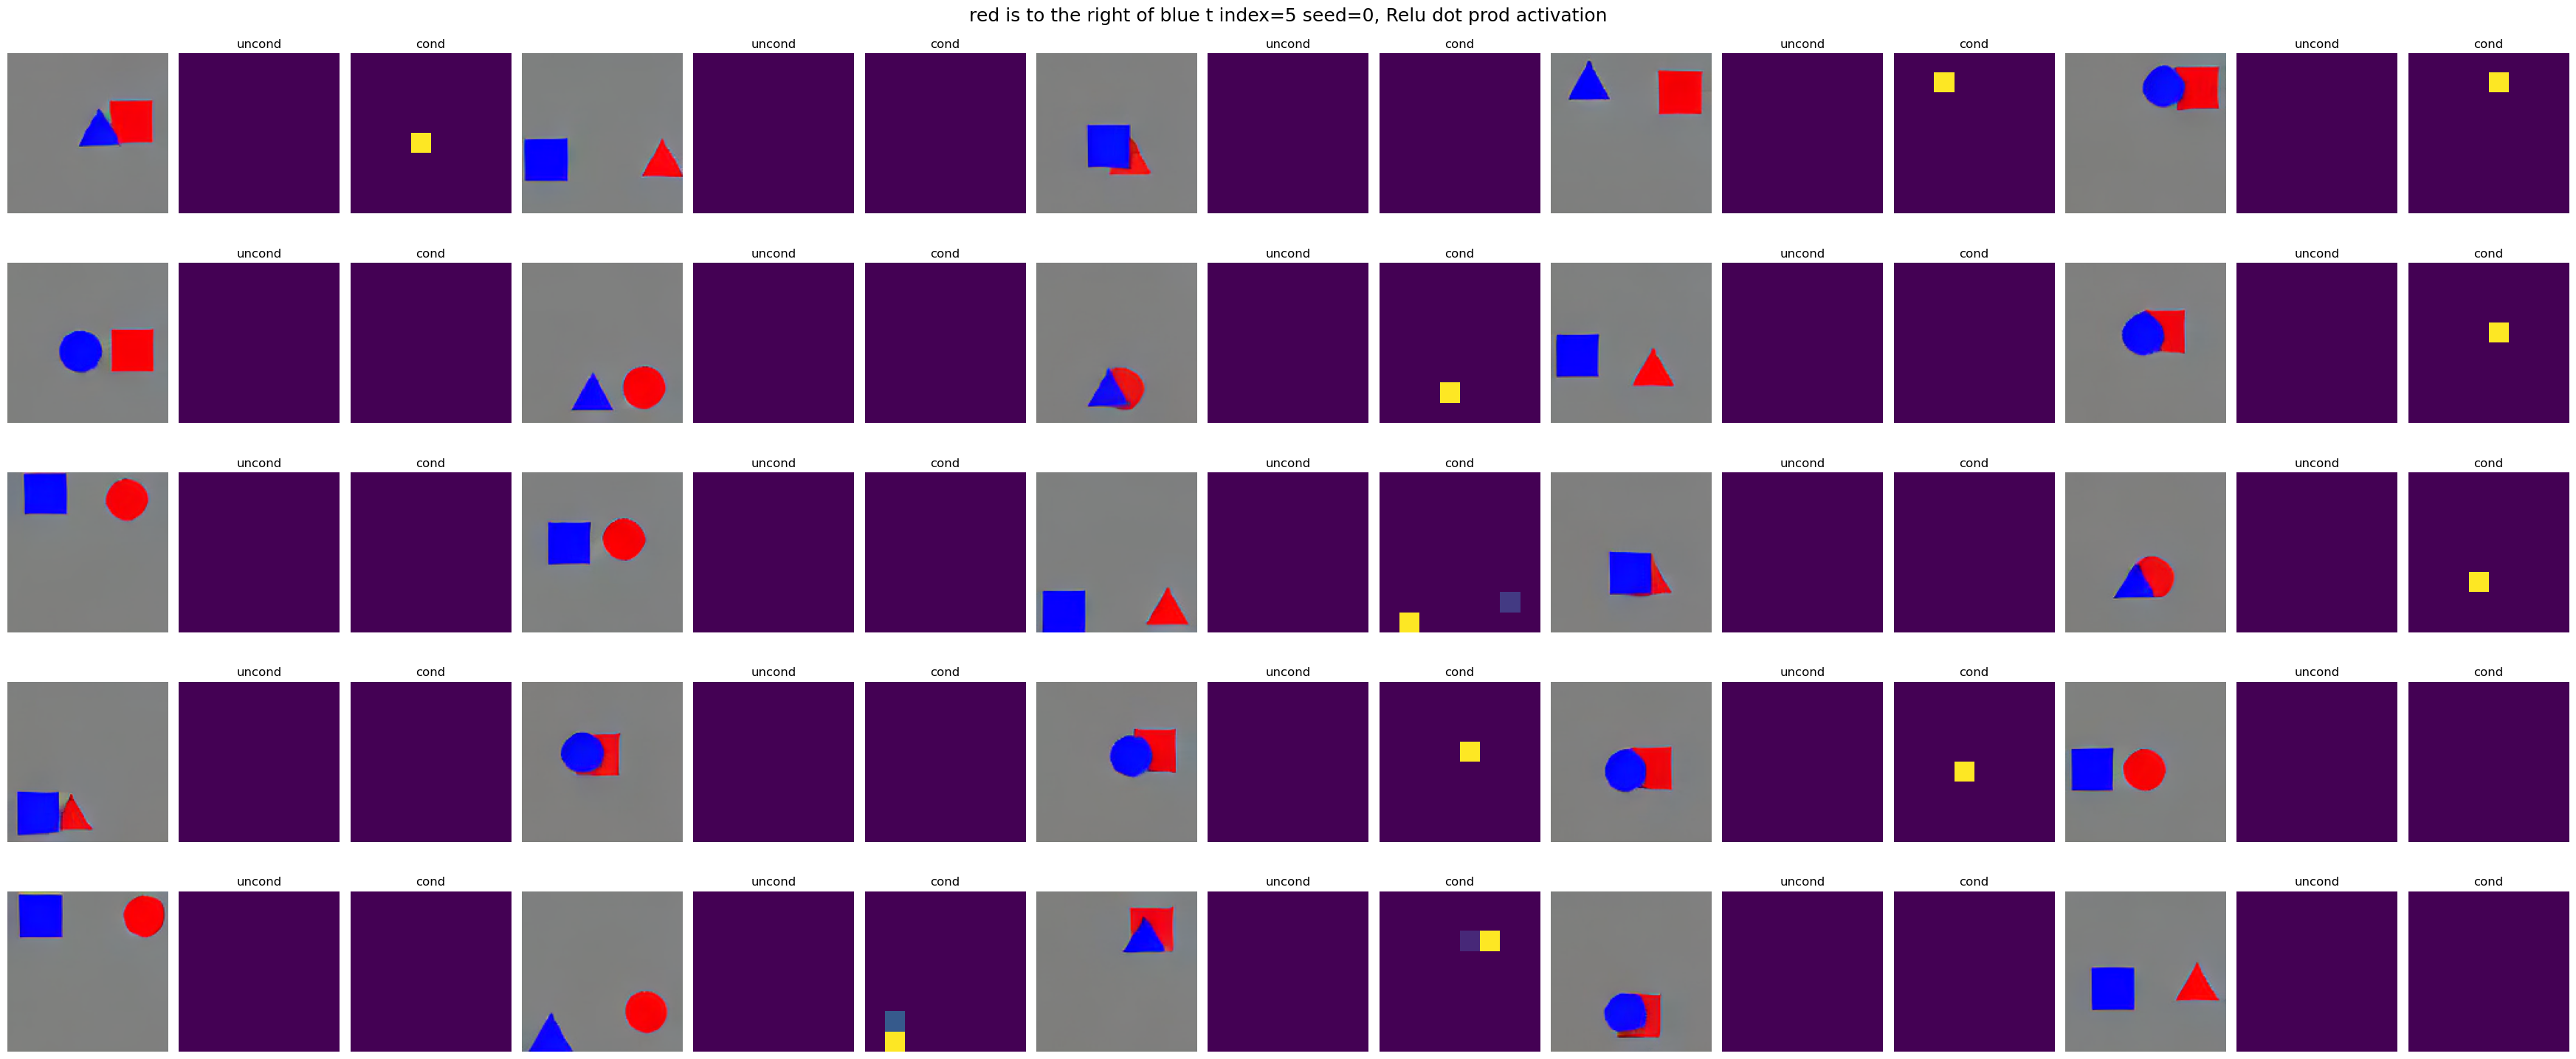

In [106]:
t_index = 5
positive_embeddings, negative_embeddings = collect_pos_neg_embeddings(saveroot, t_index=t_index, prompt_ids=range(16), seed_ids=range(10), 
                                                                      get_pos_neg_embeddings_func=get_triangle_pos_others_neg)
clf, boundary_vector, eval_dict = train_classifier_and_visualize(positive_embeddings, negative_embeddings, visualize=False, solver='liblinear')
figh = visualize_vecprod_activation_heatmap(boundary_vector, saveroot, t_index=t_index, prompt_idx=2, seed_idx=0, use_relu=True)
figh = visualize_vecprod_activation_heatmap(boundary_vector, saveroot, t_index=t_index, prompt_idx=3, seed_idx=0, use_relu=True)

  0%|          | 0/16 [00:00<?, ?it/s]

Training accuracy: 0.998
Test accuracy: 0.995
Confusion matrix: 
 [[12316    29]
 [   29   337]]
Precision (TP / (TP + FP)): 0.921
Recall (TP / (TP + FN)): 0.921


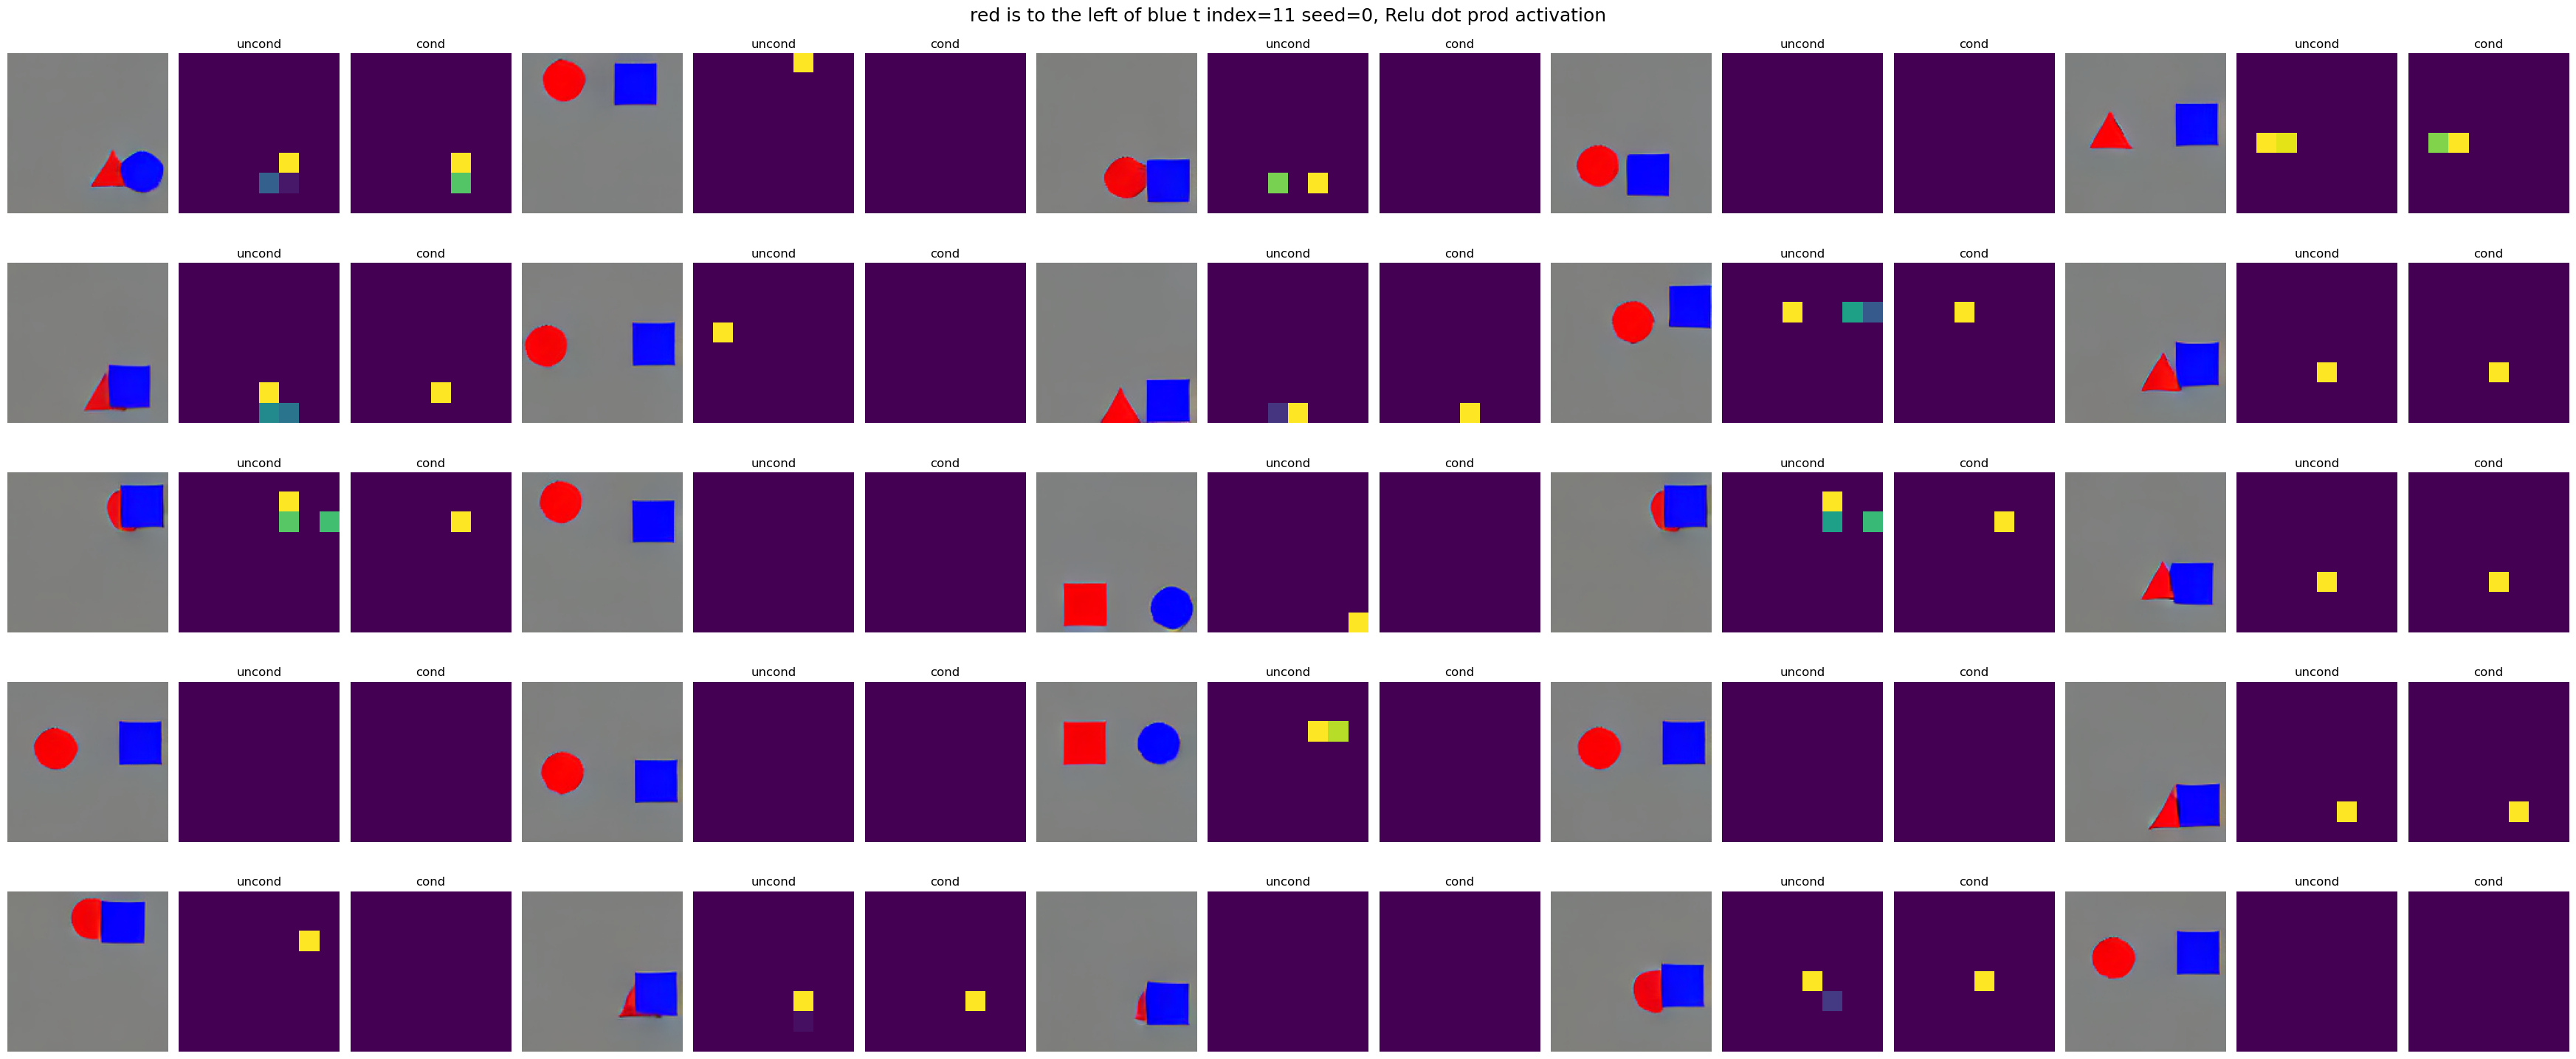

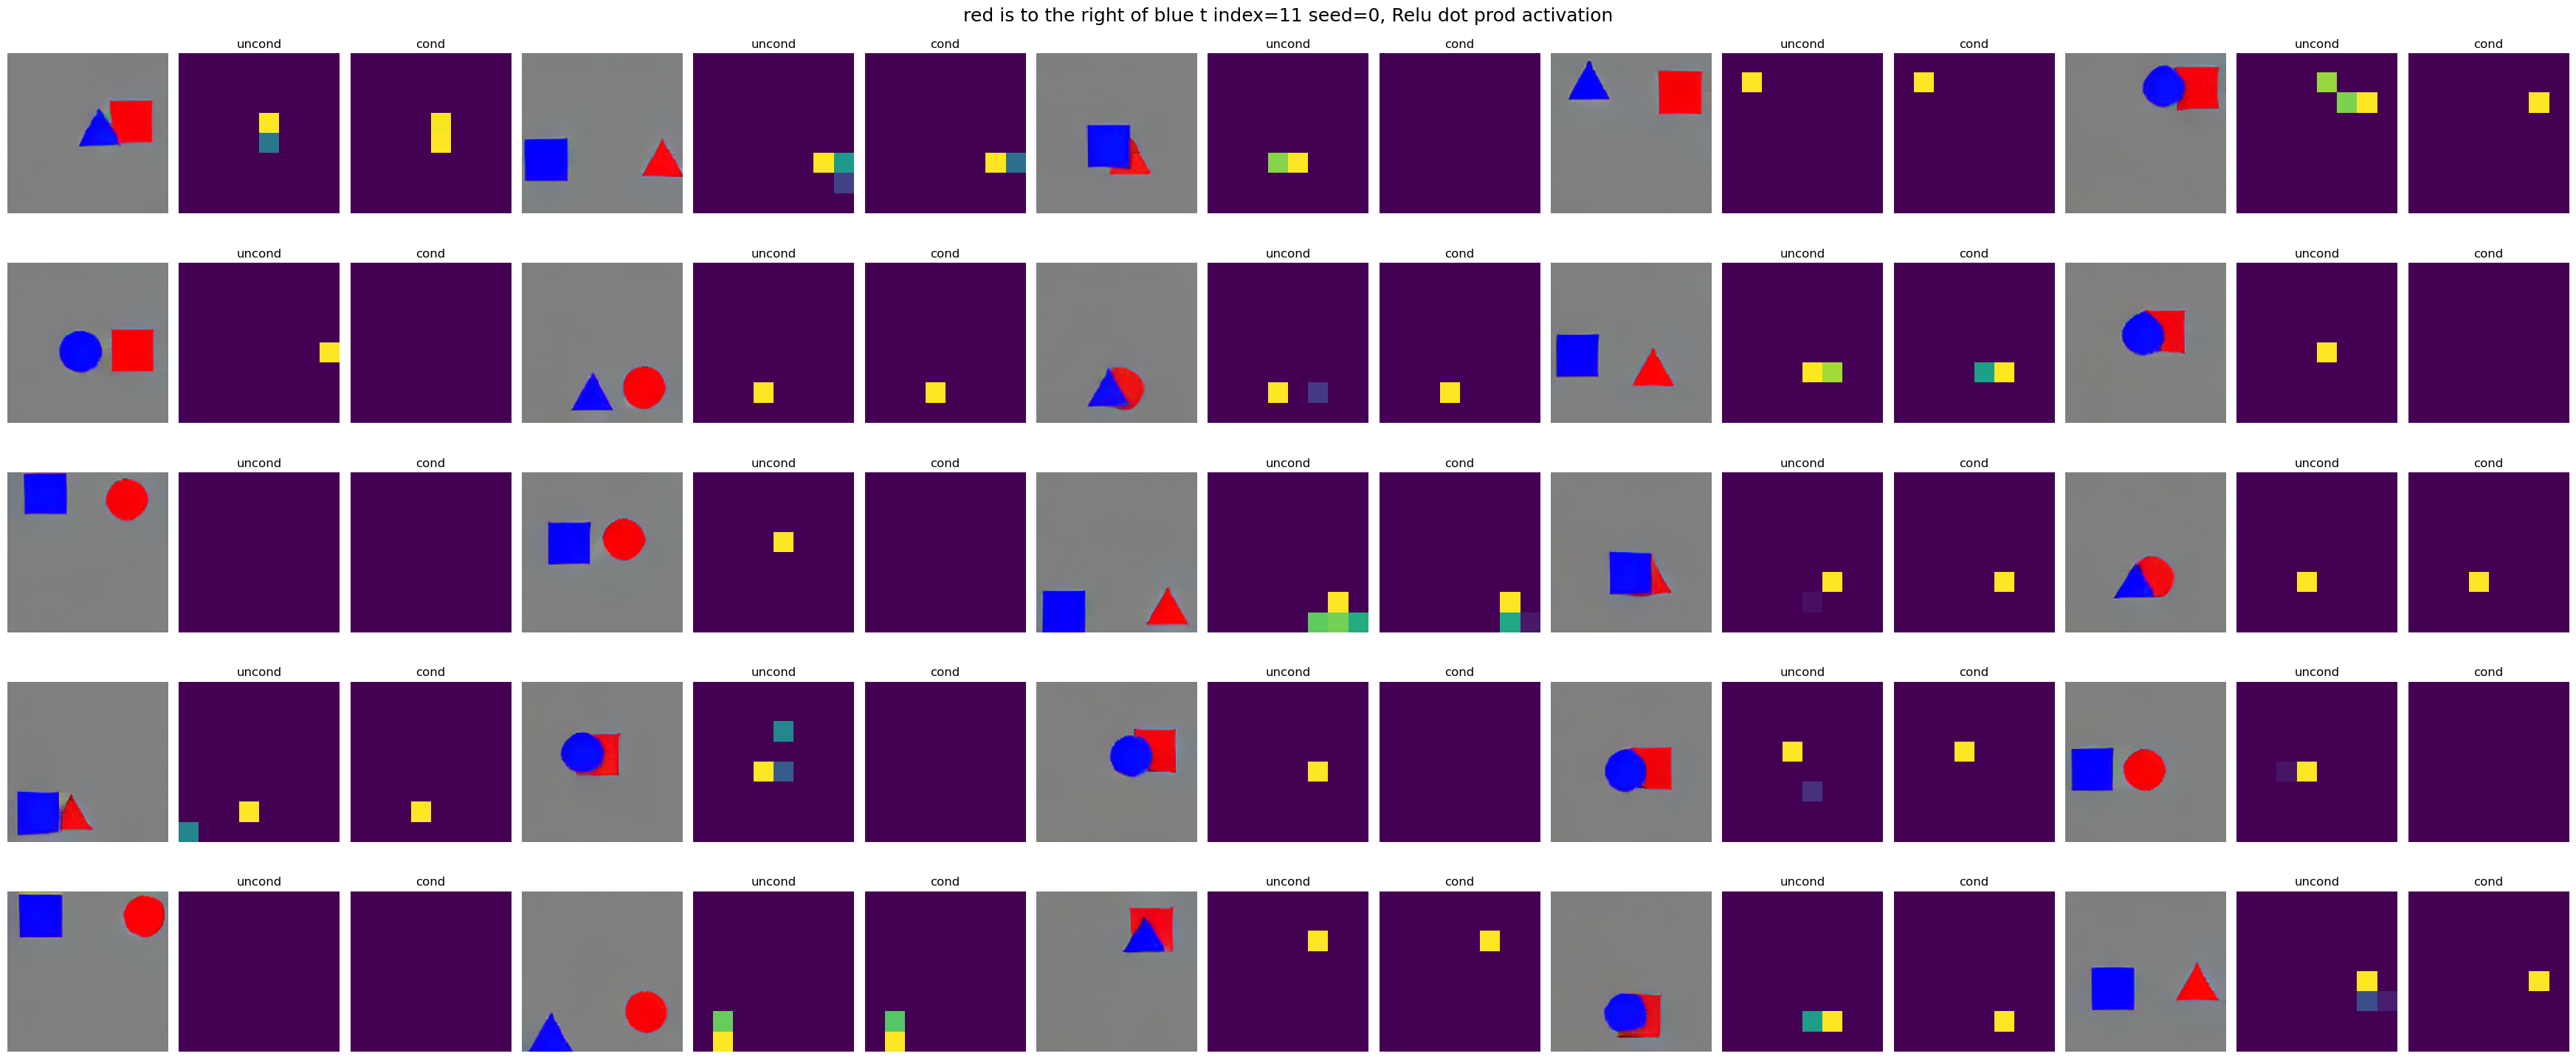

In [102]:
t_index = 11
positive_embeddings, negative_embeddings = collect_pos_neg_embeddings(saveroot, t_index=t_index, prompt_ids=range(16), seed_ids=range(10), 
                                                                      get_pos_neg_embeddings_func=get_triangle_pos_others_neg)
clf, boundary_vector = train_classifier_and_visualize(positive_embeddings, negative_embeddings, visualize=False, solver='liblinear')
visualize_vecprod_activation_heatmap(boundary_vector, saveroot, t_index=t_index, prompt_idx=2, seed_idx=0, use_relu=True)
visualize_vecprod_activation_heatmap(boundary_vector, saveroot, t_index=t_index, prompt_idx=3, seed_idx=0, use_relu=True)

  0%|          | 0/16 [00:00<?, ?it/s]

Training accuracy: 0.999
Test accuracy: 0.997
Confusion matrix: 
 [[12327    18]
 [   26   340]]
Precision (TP / (TP + FP)): 0.929
Recall (TP / (TP + FN)): 0.950


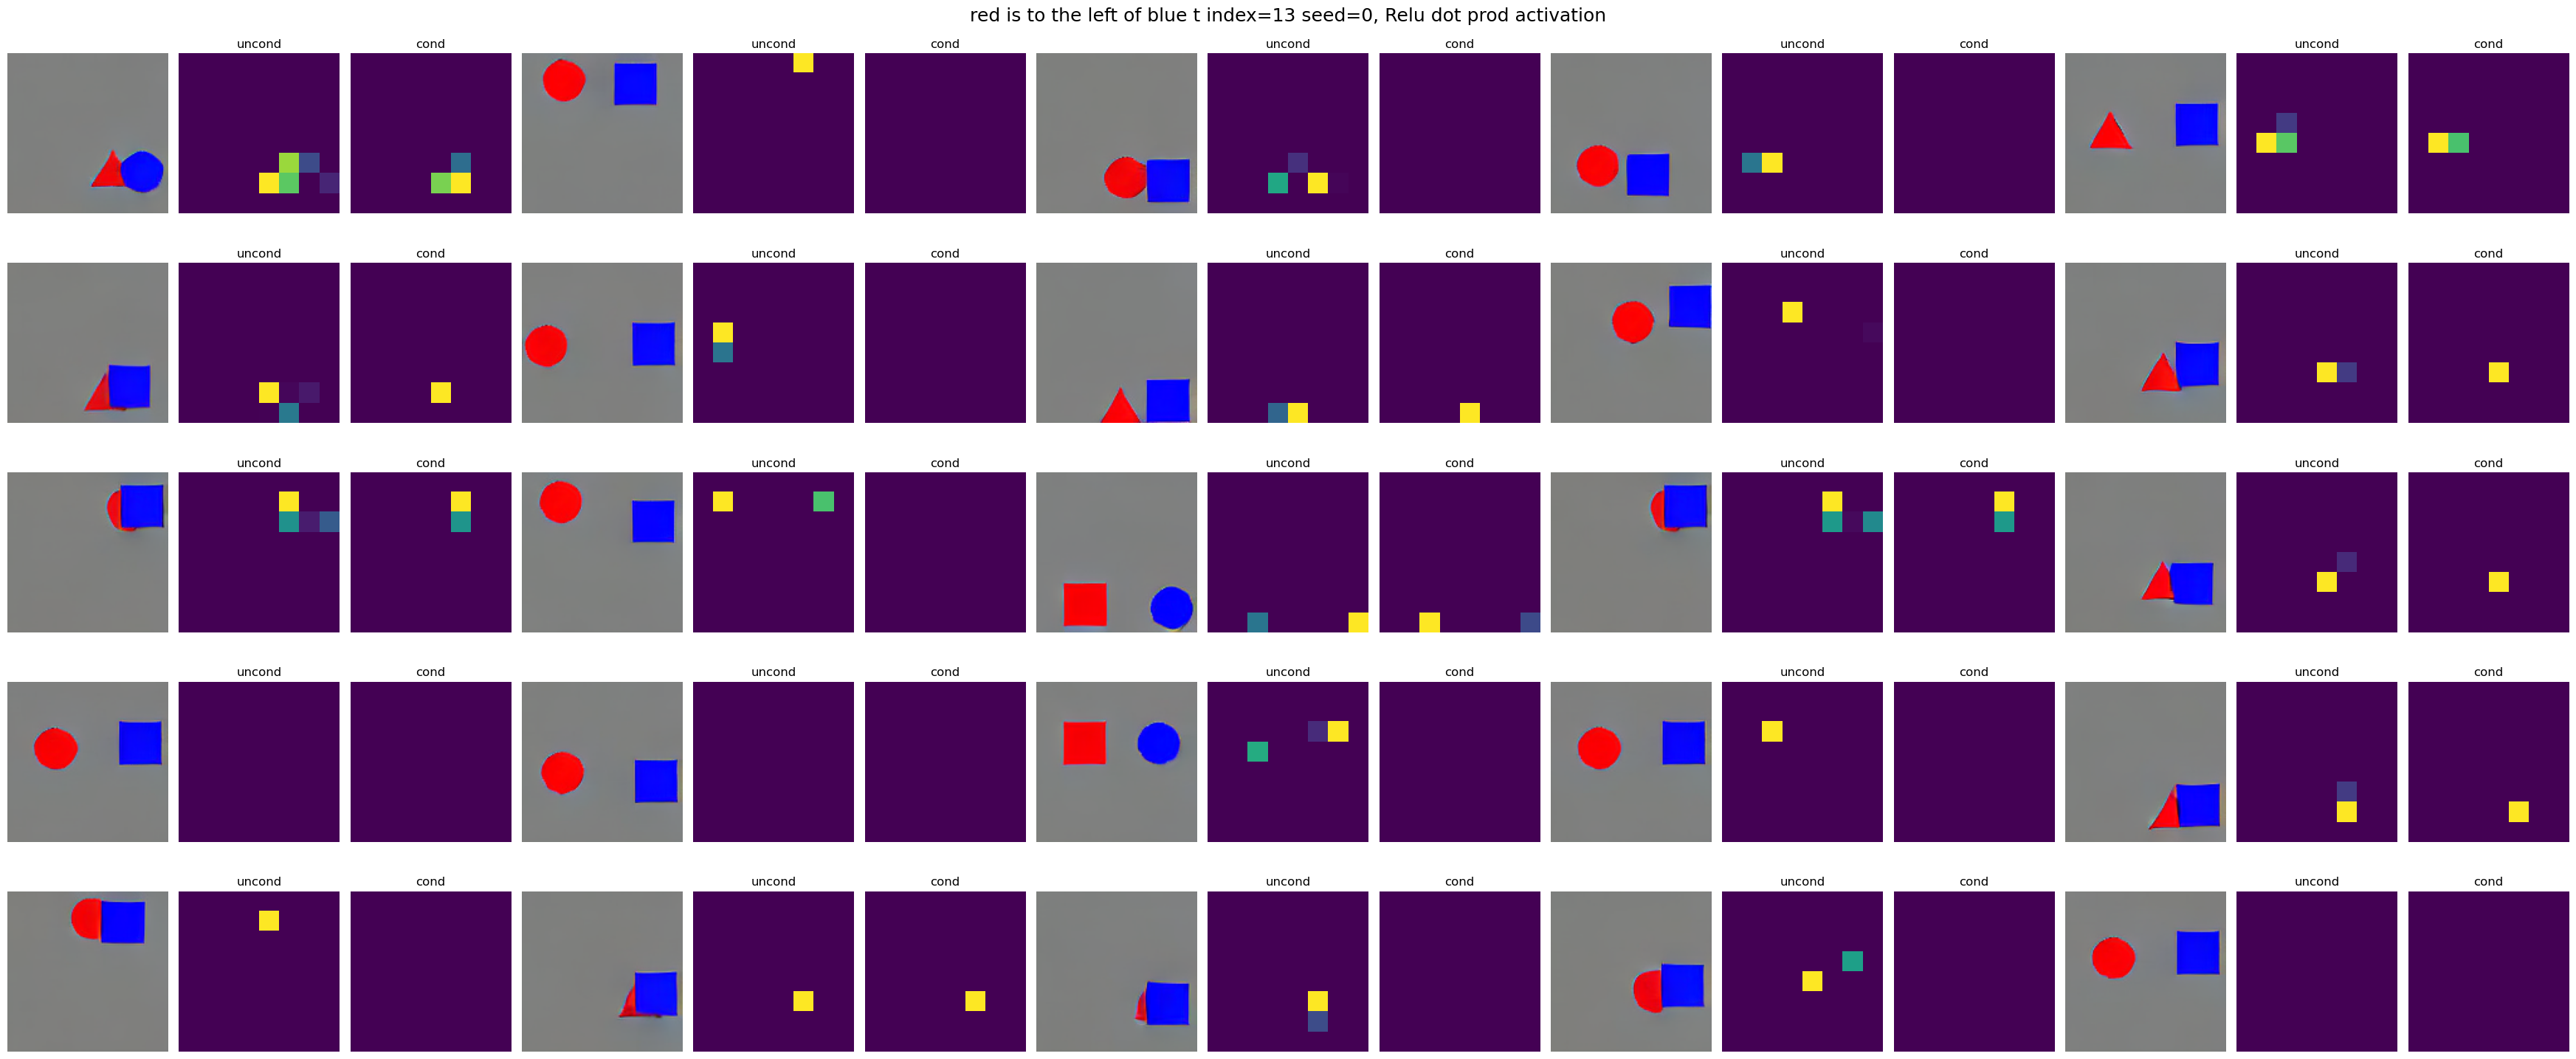

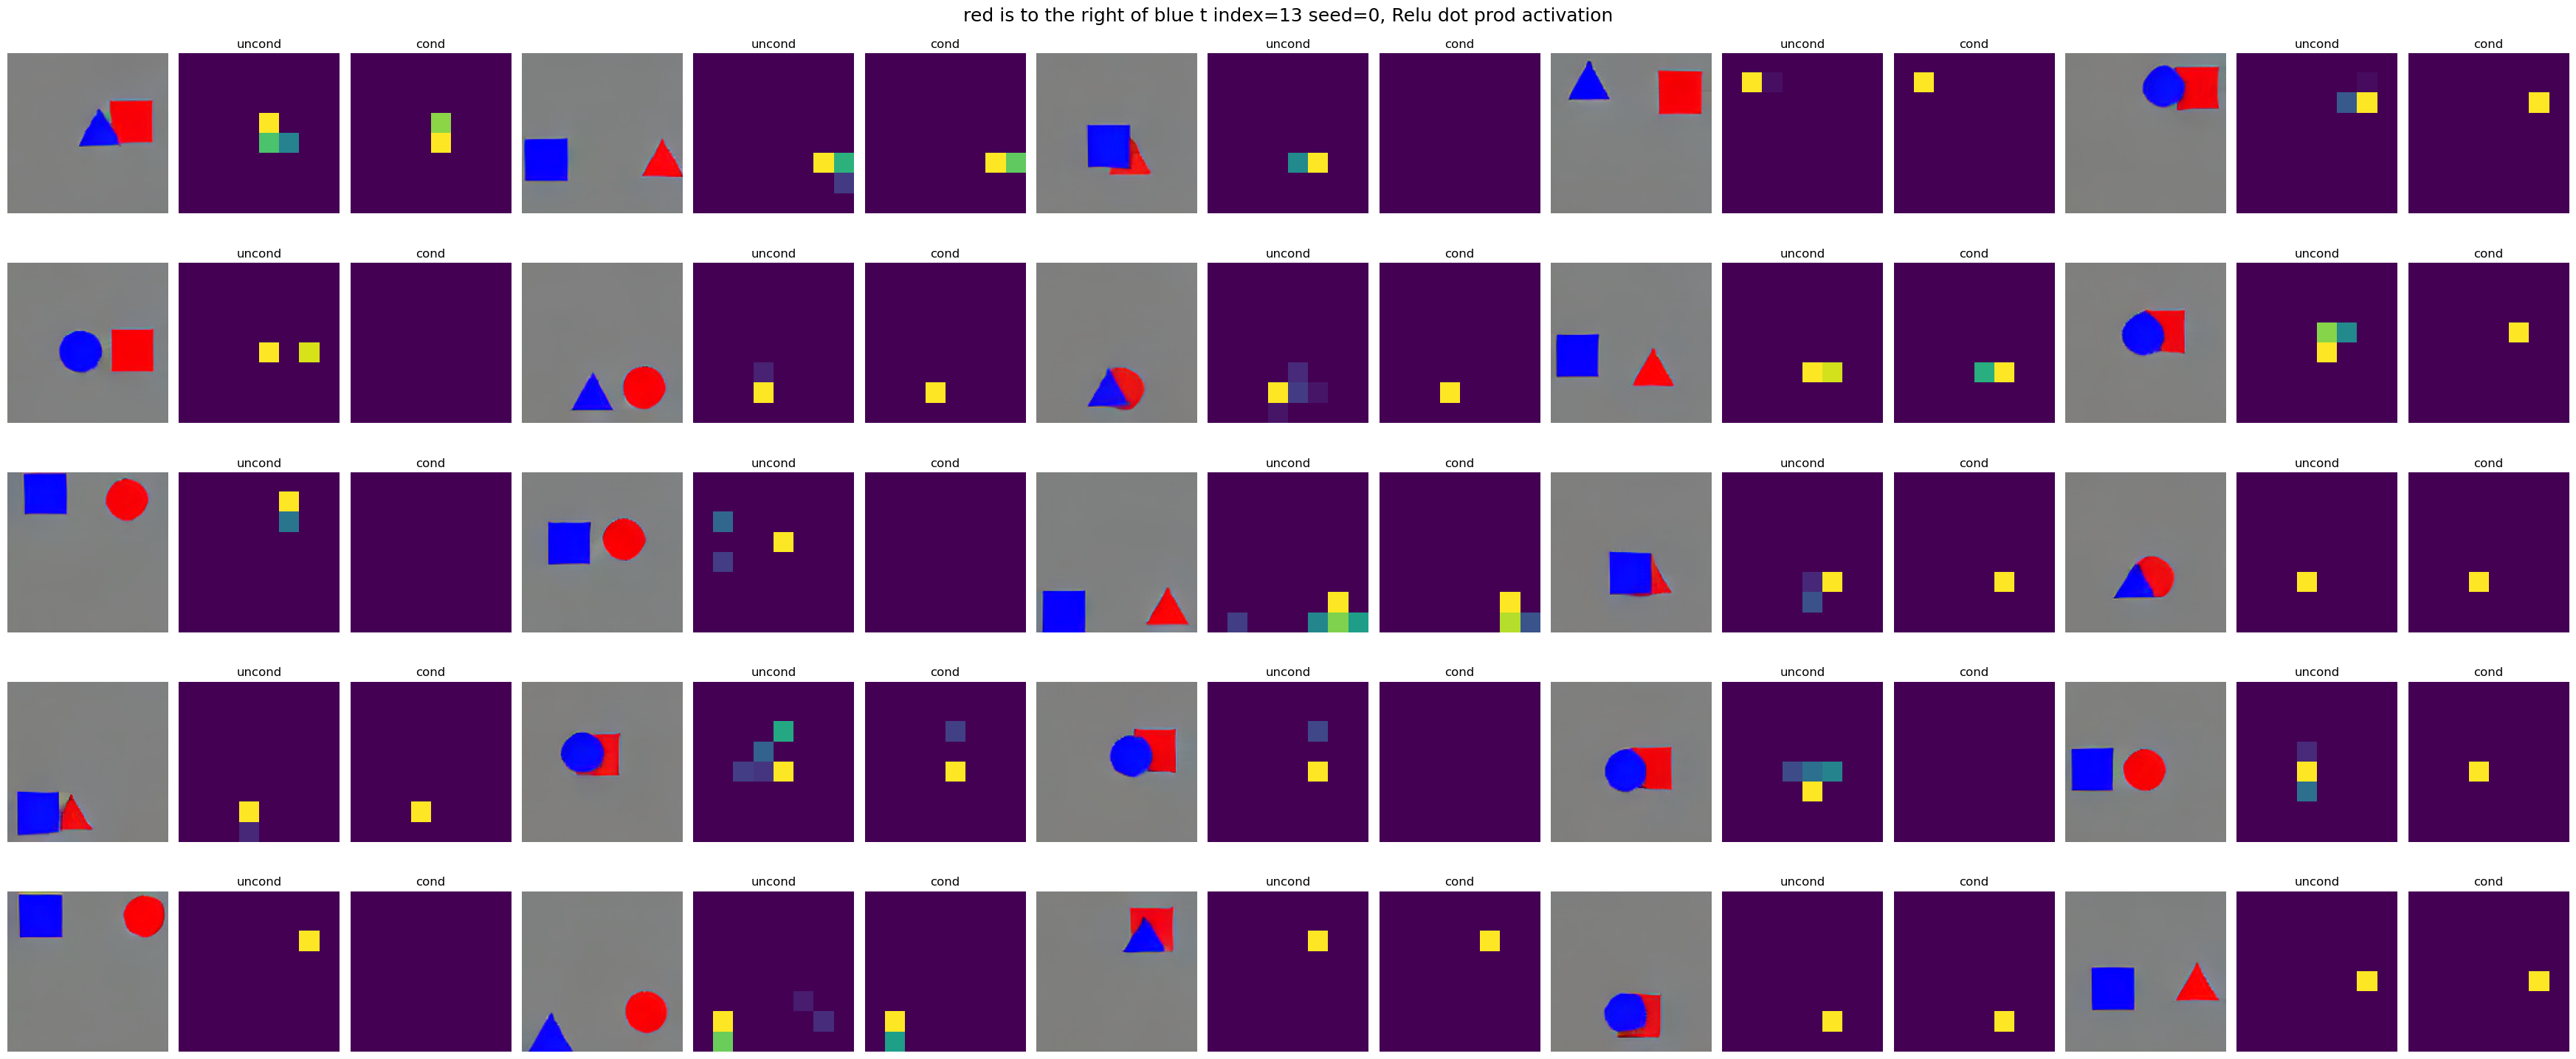

In [107]:
t_index = 13
positive_embeddings, negative_embeddings = collect_pos_neg_embeddings(saveroot, t_index=t_index, prompt_ids=range(16), seed_ids=range(10), 
                                                                      get_pos_neg_embeddings_func=get_triangle_pos_others_neg)
clf, boundary_vector = train_classifier_and_visualize(positive_embeddings, negative_embeddings, visualize=False, solver='liblinear')
visualize_vecprod_activation_heatmap(boundary_vector, saveroot, t_index=t_index, prompt_idx=2, seed_idx=0, use_relu=True)
visualize_vecprod_activation_heatmap(boundary_vector, saveroot, t_index=t_index, prompt_idx=3, seed_idx=0, use_relu=True)

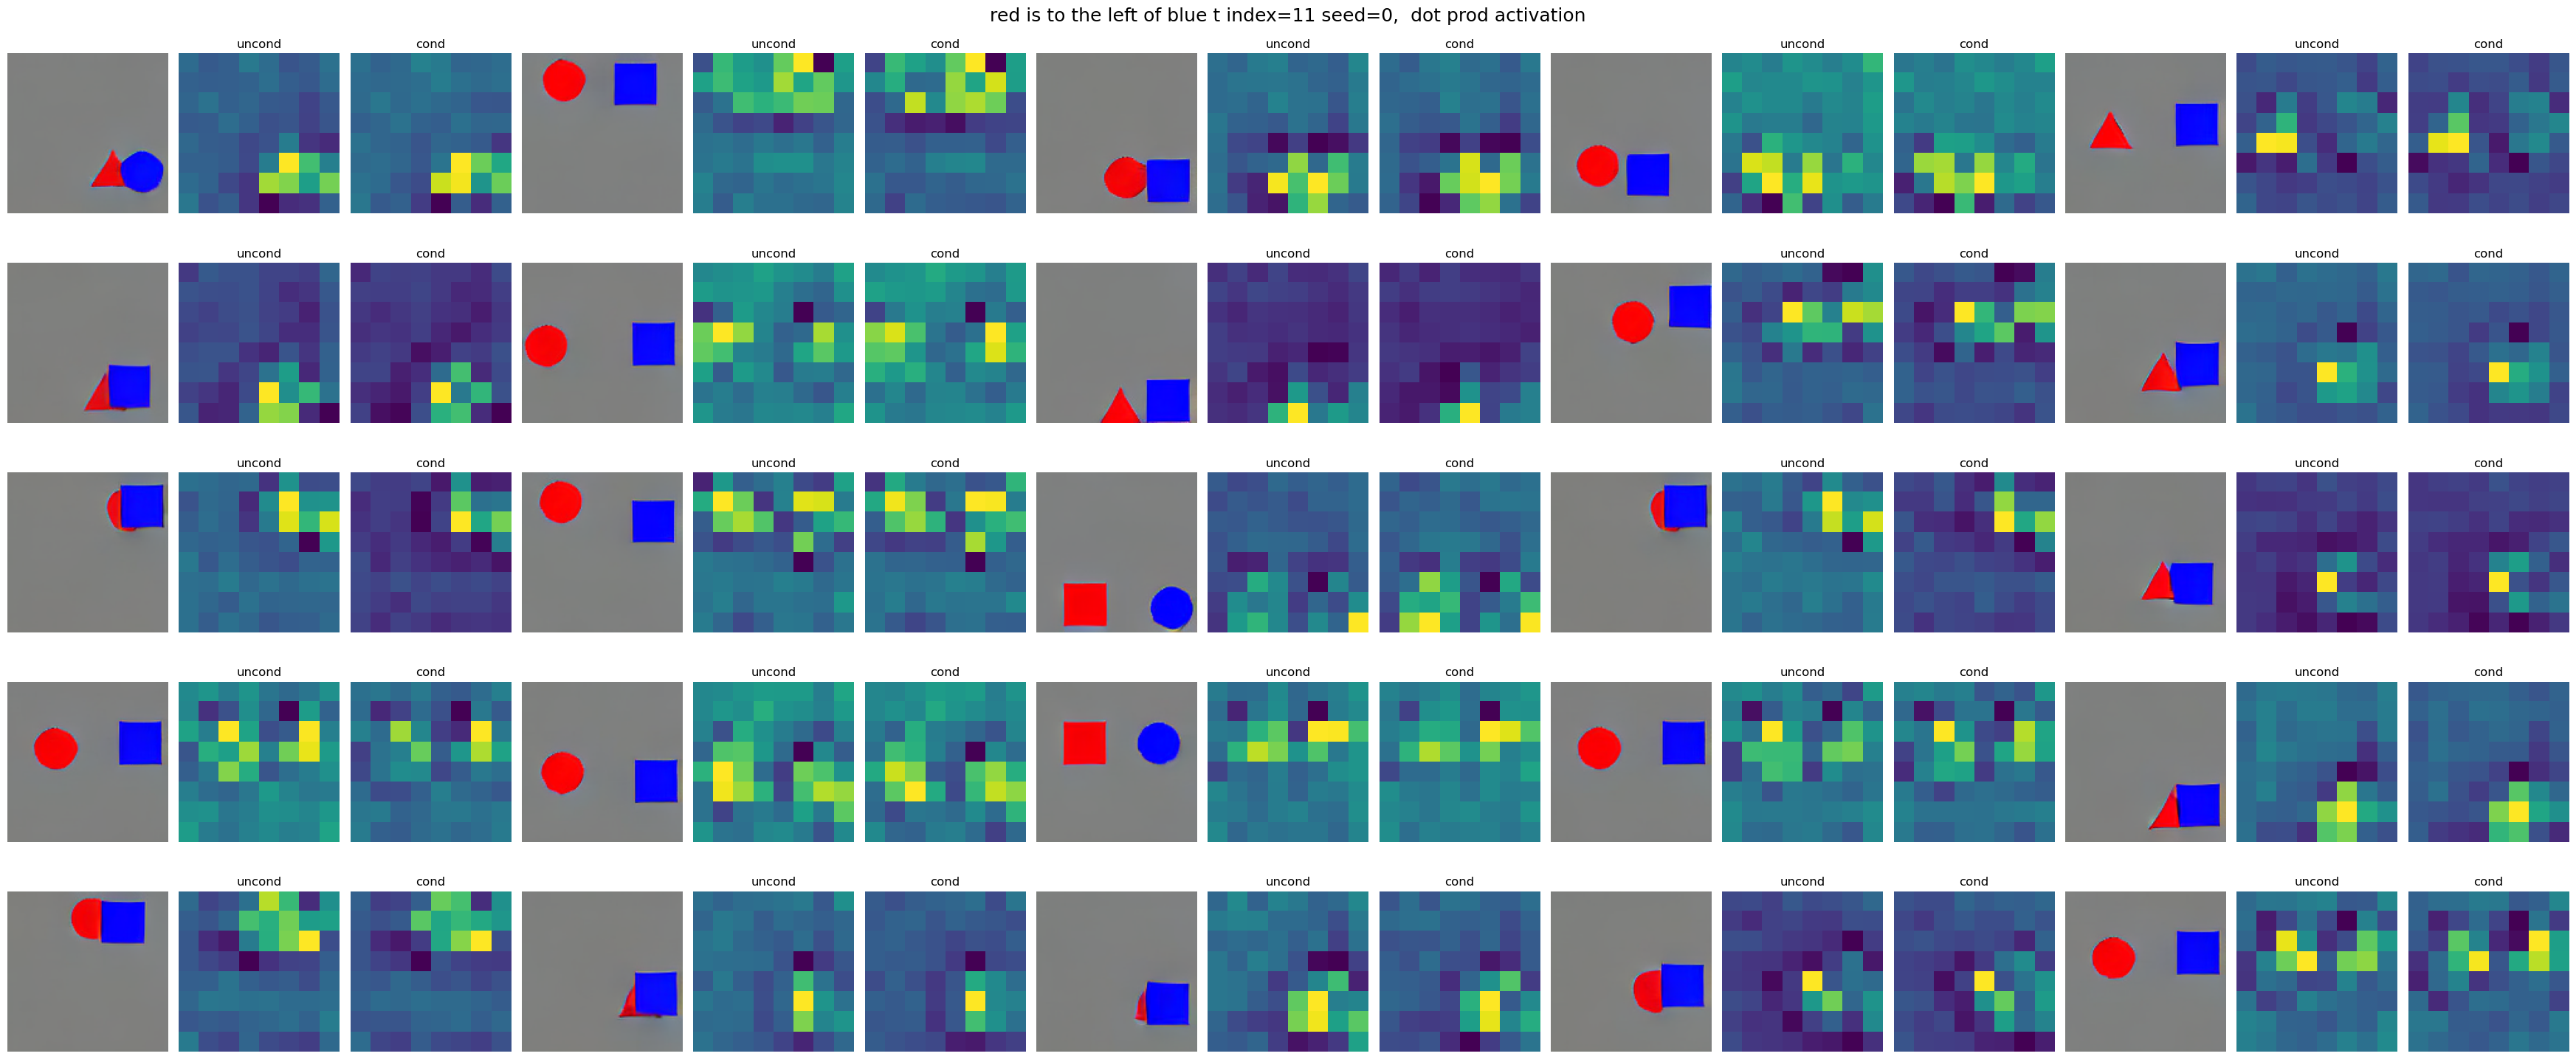

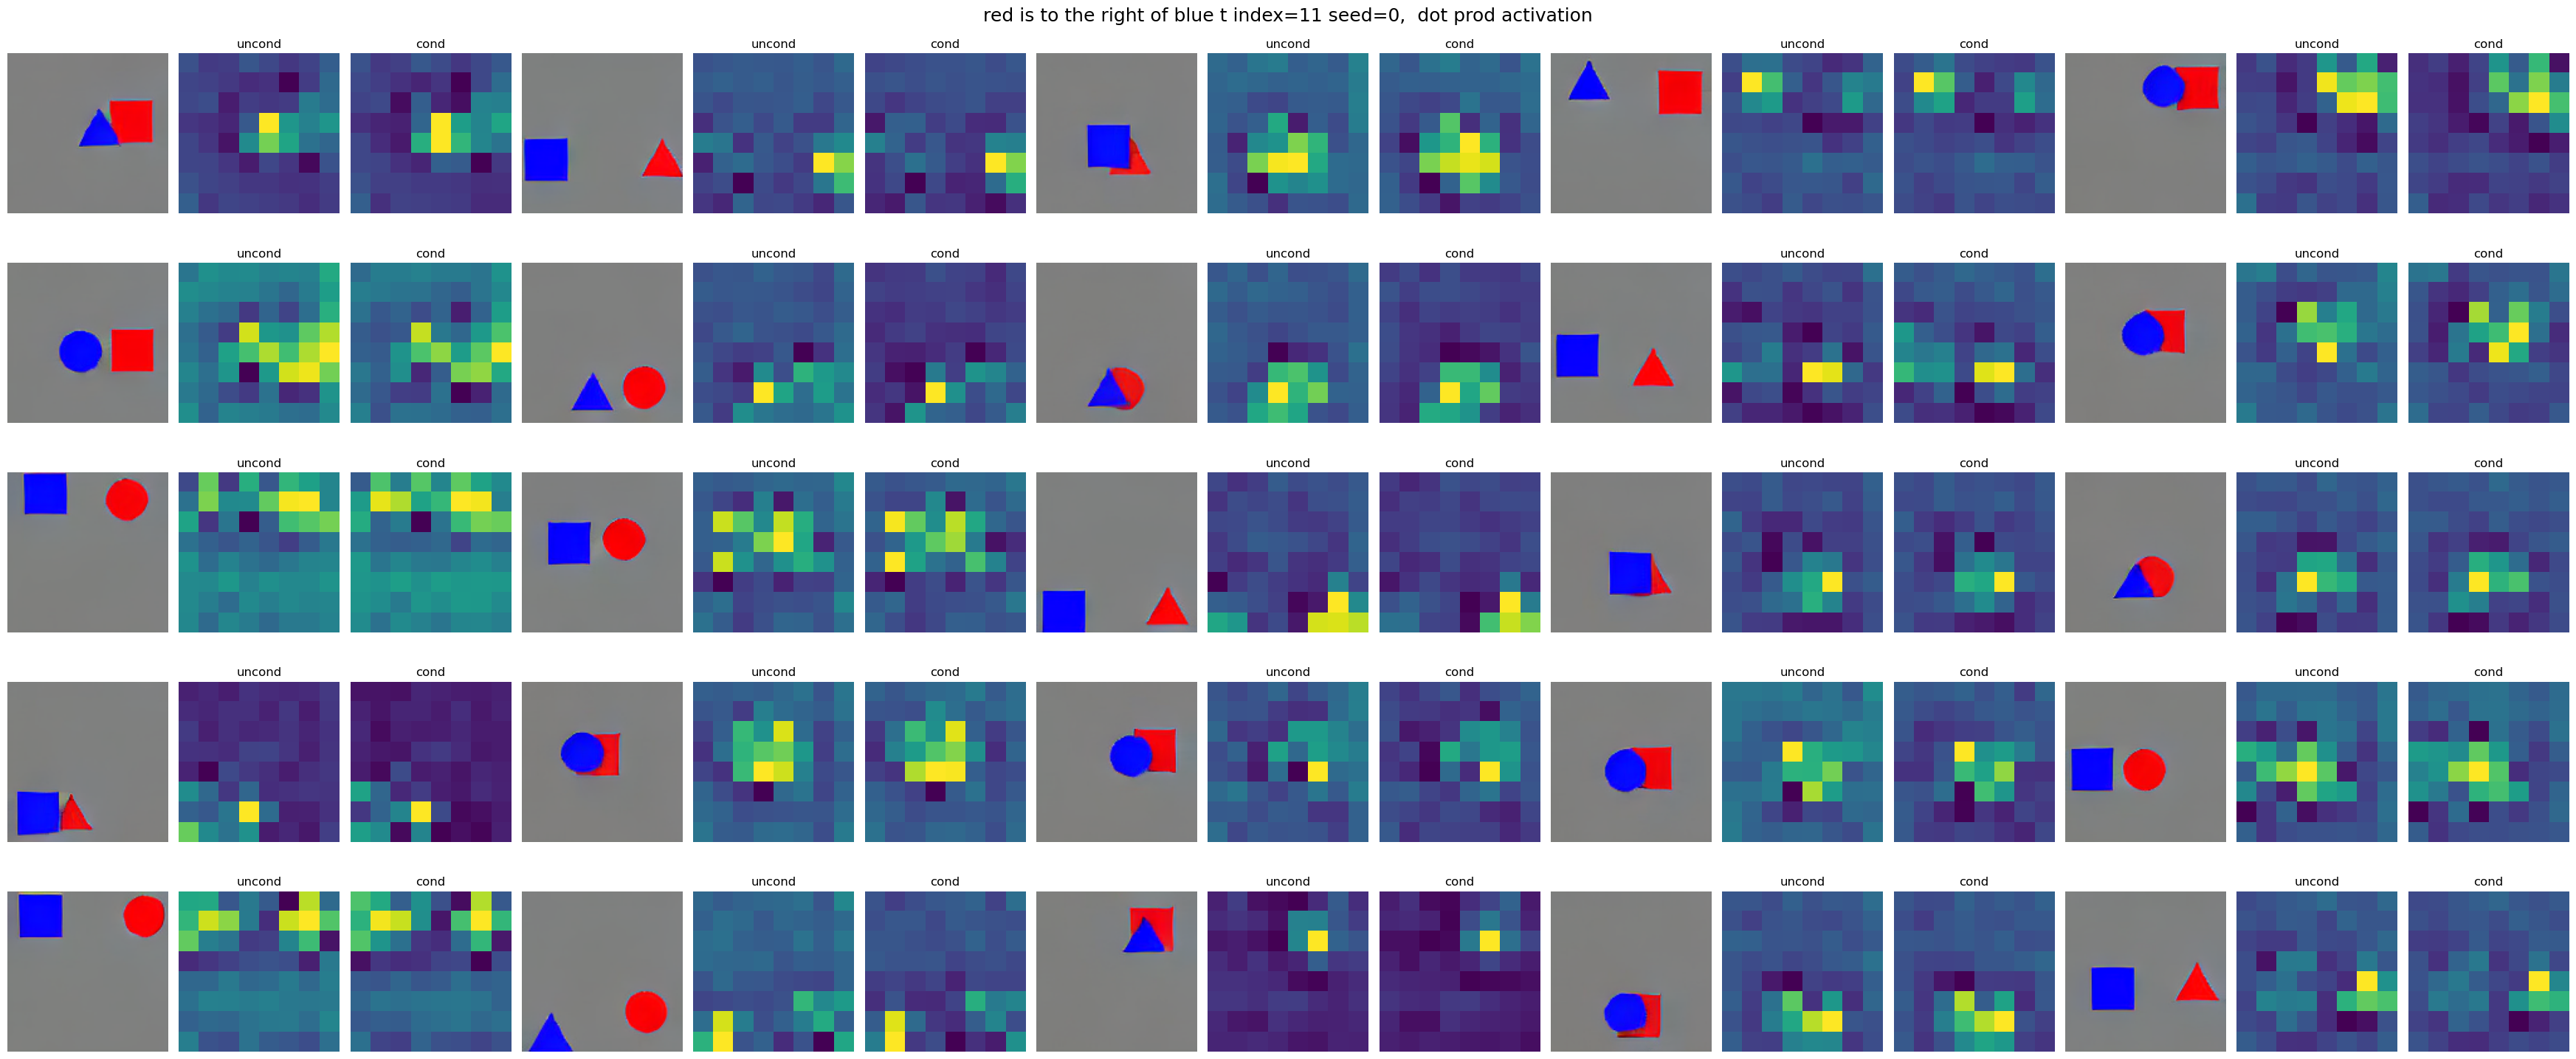

In [103]:
visualize_vecprod_activation_heatmap(boundary_vector, saveroot, t_index=t_index, prompt_idx=2, seed_idx=0, use_relu=False)
visualize_vecprod_activation_heatmap(boundary_vector, saveroot, t_index=t_index, prompt_idx=3, seed_idx=0, use_relu=False)

## Plot activation of the boundary norm vector

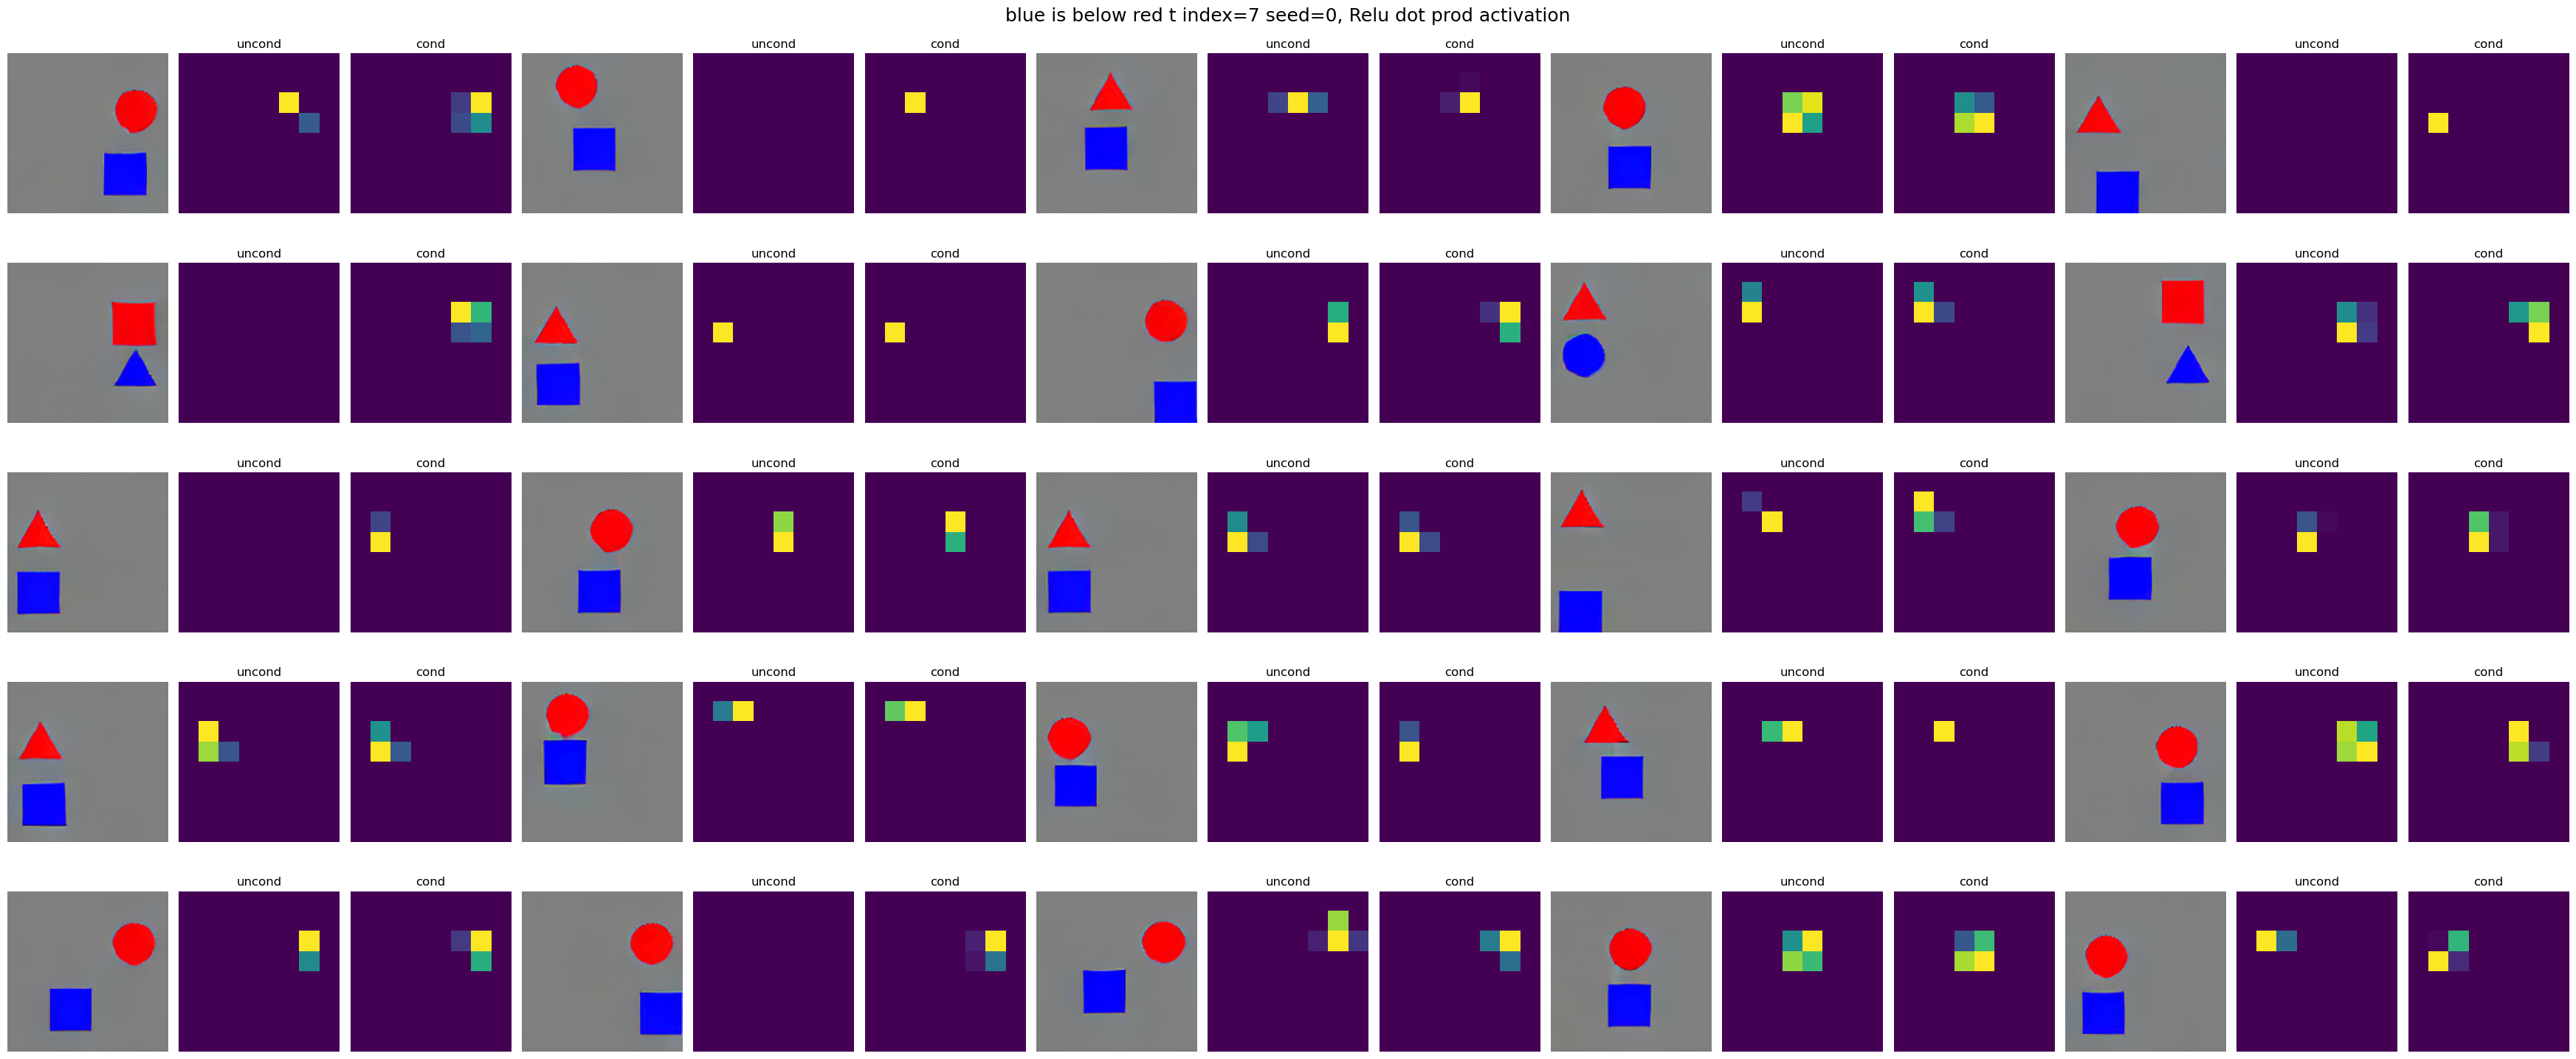

In [57]:
t_index = 7
# 0,1,8,9 are the prompts that have above or below.
seed_idx = 0
for prompt_idx in [9]:#[0,1,8,9]:
    # for seed_idx in trange(10):
    latent_file = f"red_blue_8_pos_rndembposemb_img_latent_residual_prompt{prompt_idx}_seed{seed_idx}.pkl"
    latent_path = os.path.join(saveroot, latent_file)
    with open(latent_path, 'rb') as f:
        data = pickle.load(f)
    prompt = data['prompt']
    image_logs = data['image_logs']
    batch_size = len(image_logs[0]['images'])
    residual_state_traj = data['block_11_residual_spatial_state_traj']
    activation = torch.relu(residual_state_traj @ boundary_vector) # (t steps, batch size, 8, 8)
    figh, axs = plt.subplots(5, 15, figsize=(35, 15))
    axs = axs.flatten()
    for i in range(batch_size):
        axs[3*i].imshow(image_logs[0]['images'][i])
        axs[3*i].axis('off')
        axs[3*i+1].imshow(activation[t_index, i].reshape(8, 8))
        axs[3*i+1].axis('off')
        axs[3*i+1].set_title(f"uncond")
        axs[3*i+2].imshow(activation[t_index, batch_size + i].reshape(8, 8))
        axs[3*i+2].axis('off')
        axs[3*i+2].set_title(f"cond")
    plt.suptitle(f"{prompt} t index={t_index} seed={seed_idx}, Relu dot prod activation", fontsize=18)
    plt.tight_layout()
    plt.show()
    break

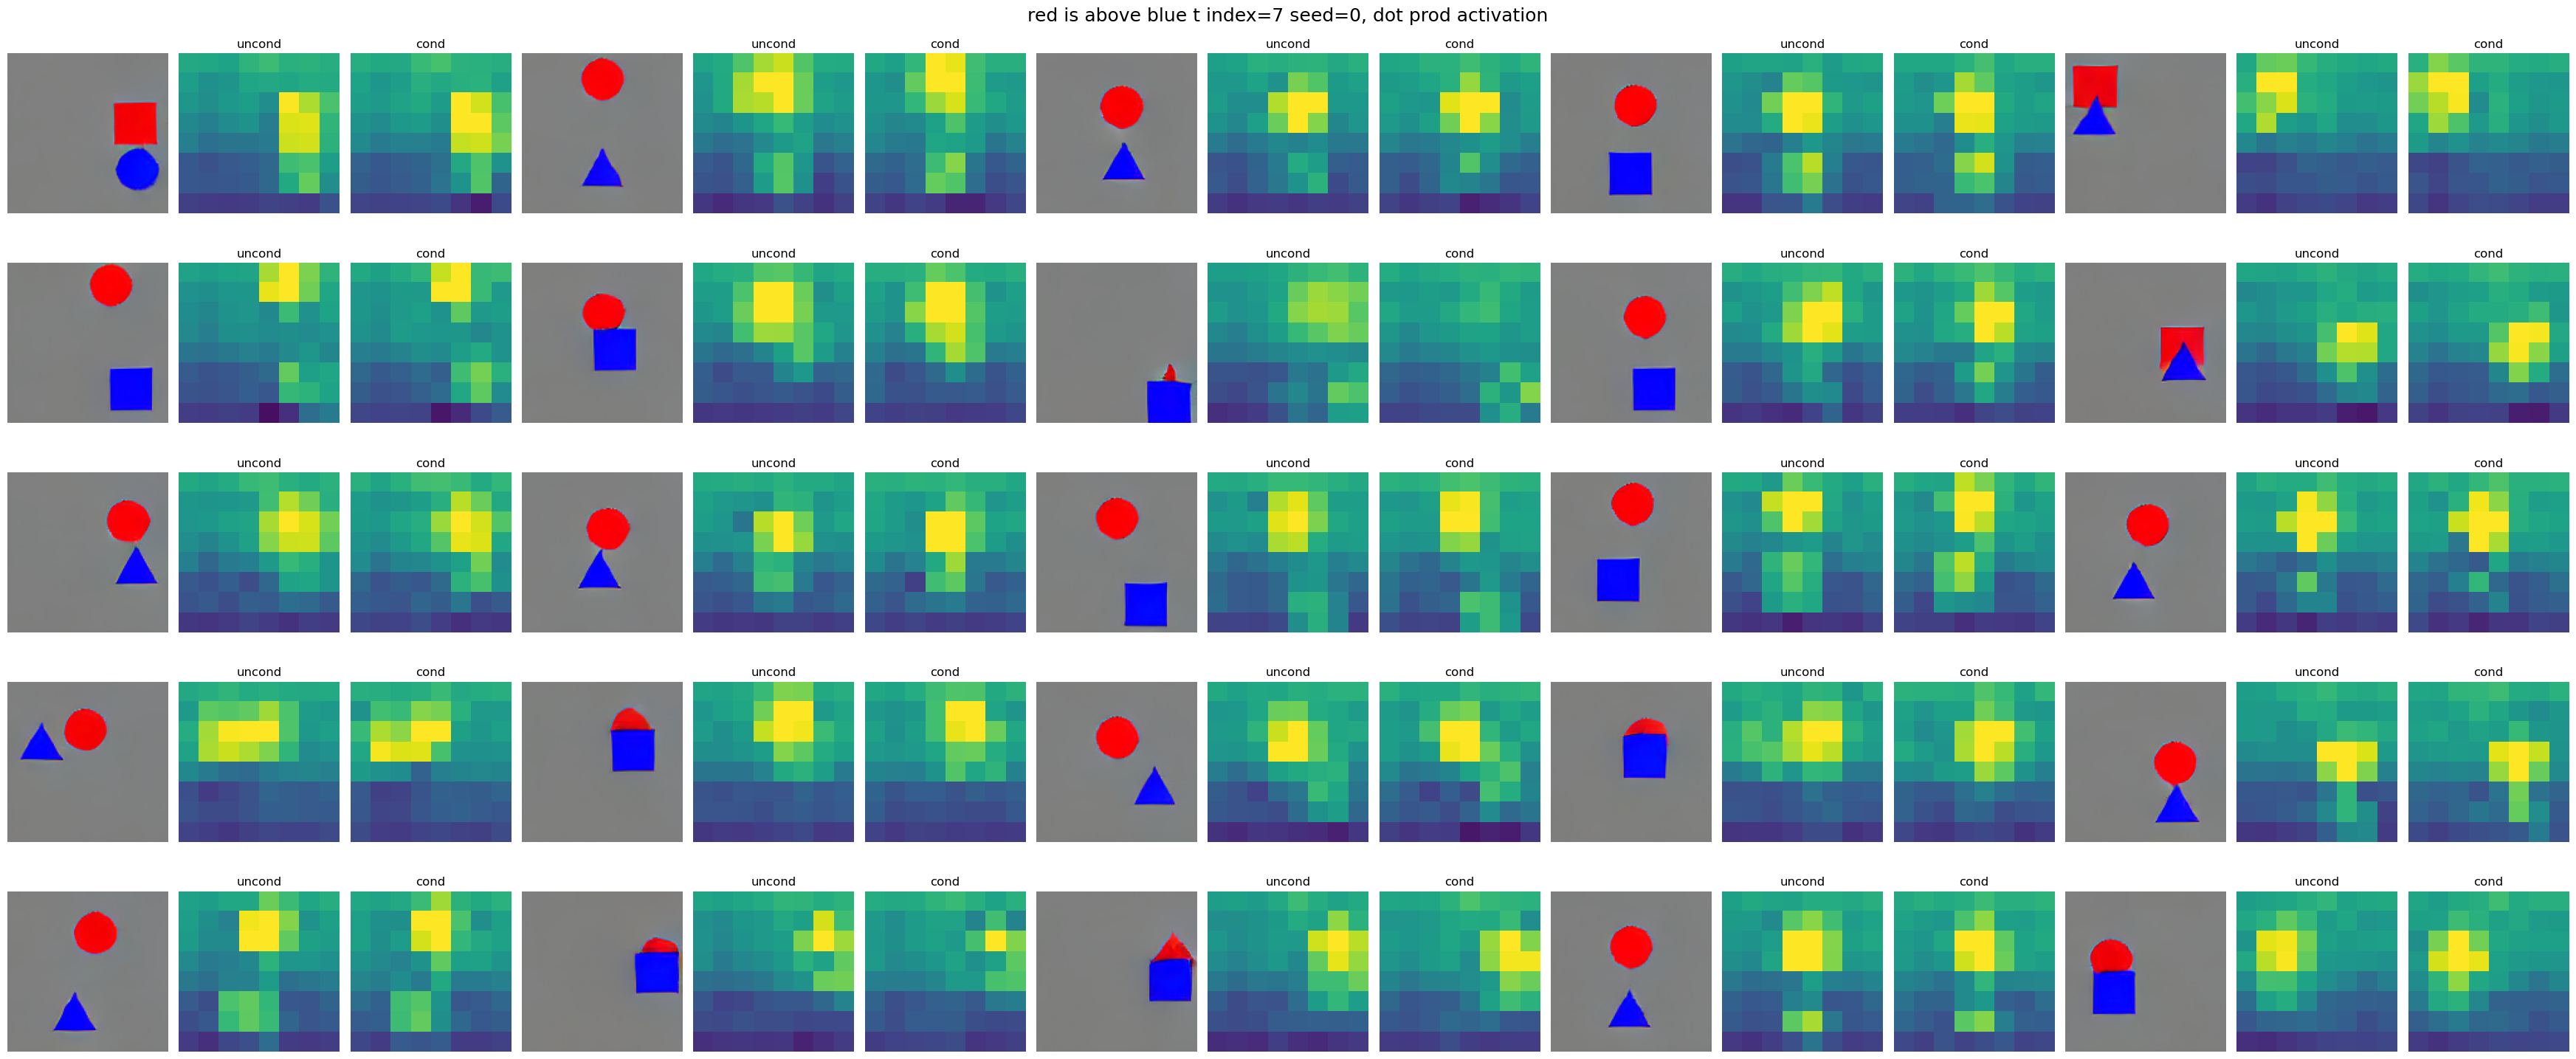

In [56]:
t_index = 7
# 0,1,8,9 are the prompts that have above or below.
seed_idx = 0
for prompt_idx in [0]:#[0,1,8,9]:
    # for seed_idx in trange(10):
    latent_file = f"red_blue_8_pos_rndembposemb_img_latent_residual_prompt{prompt_idx}_seed{seed_idx}.pkl"
    latent_path = os.path.join(saveroot, latent_file)
    with open(latent_path, 'rb') as f:
        data = pickle.load(f)
    prompt = data['prompt']
    image_logs = data['image_logs']
    batch_size = len(image_logs[0]['images'])
    residual_state_traj = data['block_11_residual_spatial_state_traj']
    activation = (residual_state_traj @ boundary_vector) # (t steps, batch size, 8, 8)
    cmax = torch.quantile(activation, 0.99)
    cmin = torch.quantile(activation, 0.01)
    figh, axs = plt.subplots(5, 15, figsize=(35, 15))
    axs = axs.flatten()
    for i in range(batch_size):
        axs[3*i].imshow(image_logs[0]['images'][i])
        axs[3*i].axis('off')
        axs[3*i+1].imshow(activation[t_index, i].reshape(8, 8), vmin=cmin, vmax=cmax)
        axs[3*i+1].axis('off')
        axs[3*i+1].set_title(f"uncond")
        axs[3*i+2].imshow(activation[t_index, batch_size + i].reshape(8, 8), vmin=cmin, vmax=cmax)
        axs[3*i+2].axis('off')
        axs[3*i+2].set_title(f"cond")
    plt.suptitle(f"{prompt} t index={t_index} seed={seed_idx}, dot prod activation", fontsize=18)
    plt.tight_layout()
    plt.show()
    break

In [25]:
(residual_state_traj @ boundary_vector).shape


torch.Size([14, 50, 8, 8])

In [ ]:
# try to classify top (+) and down (-) objects

positive_embeddings = []
negative_embeddings = []

t_index = 7

# 0,1,8,9 are the prompts that have above or below.
for prompt_idx in [0,1,8,9]:
    for seed_idx in trange(10):
        latent_file = f"red_blue_8_pos_rndembposemb_img_latent_residual_prompt{prompt_idx}_seed{seed_idx}.pkl"
        latent_path = os.path.join(saveroot, latent_file)
        with open(latent_path, 'rb') as f:
            data = pickle.load(f)
        image_logs = data['image_logs']
        batch_size = len(image_logs[0]['images'])
        residual_state_traj = data['block_11_residual_spatial_state_traj']
        for image_idx in range(batch_size):
            obj_df, obj_masks = find_classify_object_masks(image_logs[0]['images'][image_idx])
            if len(obj_df) != 2:
                continue
            obj_masks_resized = [cv2.resize(obj_mask, (8, 8)) for obj_mask in obj_masks]
            obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
            pos_embeddings, neg_embeddings = get_top_obj_pos_others_neg(residual_state_traj[t_index, batch_size + image_idx], 
                                                                            obj_df, obj_masks_resized_binary)
            positive_embeddings.append(pos_embeddings)
            negative_embeddings.append(neg_embeddings)  

positive_embeddings = np.vstack(positive_embeddings)
negative_embeddings = np.vstack(negative_embeddings)

### Debug the pos neg embedding

In [4]:
for prompt_idx in [0,1,8,9]:
    for seed_idx in trange(10):
        latent_file = f"red_blue_8_pos_rndembposemb_img_latent_residual_prompt{prompt_idx}_seed{seed_idx}.pkl"
        latent_path = os.path.join(saveroot, latent_file)
        with open(latent_path, 'rb') as f:
            data = pickle.load(f)
        image_logs = data['image_logs']
        batch_size = len(image_logs[0]['images'])
        residual_state_traj = data['block_11_residual_spatial_state_traj']
        for image_idx in range(batch_size):
            obj_df, obj_masks = find_classify_object_masks(image_logs[0]['images'][image_idx])
            if len(obj_df) != 2:
                continue
            obj_masks_resized = [cv2.resize(obj_mask, (8, 8)) for obj_mask in obj_masks]
            obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
            raise ValueError("stop")    
            # pos_embeddings, neg_embeddings = get_top_obj_pos_others_neg(residual_state_traj[t_index, batch_size + image_idx], 
            #                                                                 obj_df, obj_masks_resized_binary)

  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: stop

In [13]:
obj_df
pos_masks = []
neg_masks = []
for i in range(len(obj_df)):
    if obj_df.iloc[i]['Shape'] == "Square" and obj_df.iloc[i]['Color (RGB)'][0] > 225 and \
        obj_df.iloc[i]['Color (RGB)'][1] < 30 and obj_df.iloc[i]['Color (RGB)'][2] < 30:
        pos_masks.append(obj_masks_resized_binary[i])
        neg_masks.append(~obj_masks_resized_binary[i])
pos_masks
neg_masks


[array([[ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True, False, False,  True],
        [ True,  True,  True,  True,  True, False, False,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True]])]

In [15]:
obj_df
pos_masks = []
neg_masks = []
for i in range(len(obj_df)):
    if obj_df.iloc[i]['Shape'] == "Circle" and obj_df.iloc[i]['Color (RGB)'][0] < 30 and \
        obj_df.iloc[i]['Color (RGB)'][1] < 30 and obj_df.iloc[i]['Color (RGB)'][2] > 225:
        pos_masks.append(obj_masks_resized_binary[i])
        neg_masks.append(~obj_masks_resized_binary[i])
pos_masks
neg_masks


[array([[ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True, False,  True],
        [ True,  True,  True,  True,  True,  True, False,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True]])]

In [17]:
list(data)

['prompt',
 'random_seed',
 'image_logs',
 'latents_traj',
 'pred_traj',
 't_traj',
 'block_11_residual_spatial_state_traj']

In [20]:
data["latents_traj"][0].shape


torch.Size([15, 25, 4, 16, 16])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


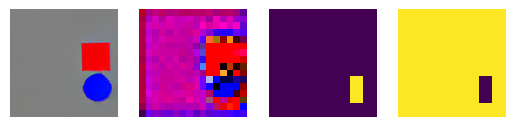

In [24]:
figh, axs = plt.subplots(1, 4)
axs = axs.flatten()
axs[0].imshow(image_logs[0]['images'][image_idx])
axs[0].axis('off')
axs[1].imshow(data["latents_traj"][0][-1, 0, 0:3].permute(1, 2, 0).cpu().numpy())
axs[1].axis('off')
axs[2].imshow(pos_masks[0])
axs[2].axis('off')
axs[3].imshow(neg_masks[0])
axs[3].axis('off')
plt.show()

In [ ]:
def get_red_triangle_pos_others_neg(latent_state, obj_df, objeect_masks):
    """
    Top object is positive, others are negative including background. 
    """
    # if len(obj_df) != 2:
    #     return np.empty([0, latent_state.shape[-1]]), np.empty([0, latent_state.shape[-1]])
    positive_embeddings = [np.empty([0, latent_state.shape[-1]])]
    negative_embeddings = [np.empty([0, latent_state.shape[-1]])]
    for i in range(len(obj_df)):
        if obj_df.iloc[i]['Shape'] == "Triangle" and obj_df.iloc[i]['Color (RGB)'][0] > 225 and \
            obj_df.iloc[i]['Color (RGB)'][1] < 30 and obj_df.iloc[i]['Color (RGB)'][2] < 30:
            positive_embeddings.append(latent_state[objeect_masks[i], :].numpy())
            negative_embeddings.append(latent_state[~objeect_masks[i], :].numpy())
    # positive_embeddings = np.vstack(positive_embeddings)
    # negative_embeddings = np.vstack(negative_embeddings)
    return positive_embeddings, negative_embeddings